# Investigating RTEM Multifamily Zone Temperatures

In [4]:
import pandas as pd
import numpy as np
from onboard.client import OnboardClient
import matplotlib.pyplot as plt
from onboard.client.models import PointSelector
from datetime import datetime, timezone, timedelta
import pytz
from onboard.client.models import TimeseriesQuery, PointData
from onboard.client.dataframes import points_df_from_streaming_timeseries
from mpl_toolkits import mplot3d

In [5]:
client = OnboardClient(api_key='ob-p-EE-rZXaUg59iBXLaRqbO-cDSRryiSunZ_N22oz31WbJotooIZ0GJ2LFTer219TmlASQ')

In [6]:
zone_temps = pd.read_csv('multifamily_zone_temperatures.csv')
zone_temps = zone_temps.drop(columns=['Unnamed: 0'])
zone_temps['timestamp'] = pd.to_datetime(zone_temps['timestamp'])
zone_temps = zone_temps.set_index('timestamp')

In [7]:
zone_temps.head(3)

198642  204984  204985  204986  204987  204988  \
timestamp                                                                   
2019-10-01 00:00:24+00:00     NaN     NaN     NaN     NaN     NaN     NaN   
2019-10-01 00:00:41+00:00     NaN     NaN     NaN     NaN     NaN     NaN   
2019-10-01 00:01:00+00:00     NaN     NaN     NaN     NaN     NaN     NaN   

                           204989  204990  204991     204992  ...  311215  \
timestamp                                                     ...           
2019-10-01 00:00:24+00:00     NaN     NaN     NaN        NaN  ...     NaN   
2019-10-01 00:00:41+00:00     NaN     NaN     NaN        NaN  ...     NaN   
2019-10-01 00:01:00+00:00     NaN     NaN     NaN  74.862503  ...     NaN   

                           311216  311217  311218  198634  311219  198635  \
timestamp                                                                   
2019-10-01 00:00:24+00:00     NaN     NaN     NaN     NaN     NaN     NaN   
2019-10-01 00:00:41+00:00     NaN     NaN     NaN     NaN     NaN     NaN   
2019-10-01 00:01:00+00:00     NaN     NaN     NaN     NaN     NaN     NaN   

                           198638  198640  198641  
timestamp                                          
2019-10-01 00:00:24+00:00     NaN     NaN     NaN  
2019-10-01 00:00:41+00:00     NaN     NaN     NaN  
2019-10-01 00:01:00+00:00     NaN     NaN     NaN  

[3 rows x 1339 columns]

## Taking an initial look at the collected data

In [8]:
all_buildings = pd.json_normalize(client.get_all_buildings())
selected_buildings = all_buildings[all_buildings['info.customerType'] == 'Multifamily']
selected_buildings.head(3)

id  org_id    name address     sq_ft image_src bms_manufacturer  \
0  441       5   88737    None  551143.0      None             None   
4  248       5  116742    None  127000.0      None             None   
6  434       5  129666    None   56090.0      None             None   

  bms_product_name bms_version          timezone  ... info.sunend  \
0             None        None  America/New_York  ...               
4             None        None  America/New_York  ...               
6             None        None  America/New_York  ...               

   info.geoCity  info.geoState info.m2fstart info.satstart info.sunstart  \
0         Bronx             NY                                             
4      New York             NY                                             
6      Brooklyn             NY                                             

  info.yearBuilt info.geoCountry info.weatherRef info.customerType  
0                             US                       Multifamily  
4                             US                       Multifamily  
6                             US                       Multifamily  

[3 rows x 26 columns]

In [9]:
query = PointSelector()
query.point_types = ['Zone Temperature']
query.buildings = selected_buildings['id'].to_list()
selection = client.select_points(query)
sensor_metadata = pd.DataFrame(client.get_points_by_ids(selection['points']))

In [10]:
sensor_metadata.head(3)

id  building_id  last_updated  first_updated device network_device  \
0  197234          127  1.546740e+12   1.530418e+12                  None   
1  197235          127  1.546740e+12   1.530418e+12                  None   
2  197236          127  1.546740e+12   1.530418e+12                  None   

  objectId       name description units tagged_units  raw_unit_id  value  \
0             Apt 11C     Apt 11C     F            f            2    0.0   
1             Apt 11D     Apt 11D     F            f            2  74.30   
2           Apt 11D.1   Apt 11D.1     F            f            2  79.53   

               type  point_type_id  measurement_id  \
0  Zone Temperature             77               1   
1  Zone Temperature             77               1   
2  Zone Temperature             77               1   

                    datasource_hash                                     topic  \
0  2725f3aeb78c7264926ba2e9969870e3    nyserda+0000089089+Site-Sensor+Apt 11C   
1  33b4e538e37e7b04c4601e64c1f4c372    nyserda+0000089089+Site-Sensor+Apt 11D   
2  8dc4807be97163e1c33f0706df6a5c01  nyserda+0000089089+Site-Sensor+Apt 11D.1   

  state_text  equip_id  
0       None     17862  
1       None     17862  
2       None     17862

We can use the sensor metadata to seperate the time series data out by apartment and identify problmatic points...

For some strange reason, the value is a string, going to change this first...

Removing the sensor metadata that isn't found in the time series data...

In [11]:
sensor_metadata['id_str'] = sensor_metadata.apply(lambda row : str(row['id']), axis = 1)
sensor_metadata = sensor_metadata[sensor_metadata['id_str'].isin(zone_temps.columns)]

In [12]:
def to_float(value_string):
    try:
        f = float(value_string)
    except:
        f = -1
    return f

In [13]:
sensor_metadata['value_float'] = sensor_metadata.apply(lambda row : to_float(row['value']), axis = 1)

In [14]:
sensor_metadata.describe()

id  building_id  last_updated  first_updated  raw_unit_id  \
count    1339.000000  1339.000000  1.339000e+03   1.339000e+03       1339.0   
mean   283047.610157   375.894698  1.600761e+12   1.567907e+12          2.0   
std     50807.638521   101.580110  1.330102e+10   1.137517e+10          0.0   
min    197314.000000   128.000000  1.575382e+12   1.536553e+12          2.0   
25%    273955.500000   357.000000  1.590170e+12   1.561954e+12          2.0   
50%    284588.000000   423.000000  1.606798e+12   1.567310e+12          2.0   
75%    310790.500000   441.000000  1.609476e+12   1.575180e+12          2.0   
max    427768.000000   467.000000  1.627790e+12   1.598918e+12          2.0   

       point_type_id  measurement_id      equip_id  value_float  
count         1339.0          1339.0   1339.000000  1339.000000  
mean            77.0             1.0  27247.139656    76.319970  
std              0.0             0.0   4578.826594     8.378199  
min             77.0             1.0  17871.000000    32.000000  
25%             77.0             1.0  26597.000000    73.400000  
50%             77.0             1.0  28813.000000    76.660000  
75%             77.0             1.0  28813.000000    79.470000  
max             77.0             1.0  36559.000000   155.000000

There are some extremes, let's take a look a them

In [15]:
sensor_metadata[sensor_metadata['value_float'] >110]

id  building_id  last_updated  first_updated device network_device  \
517  199163          154  1.585057e+12   1.569506e+12                  None   
518  199164          154  1.585057e+12   1.569506e+12                  None   
519  199165          154  1.584601e+12   1.569506e+12                  None   
520  199166          154  1.585057e+12   1.569506e+12                  None   
521  199167          154  1.585058e+12   1.569506e+12                  None   
522  199168          154  1.585057e+12   1.569506e+12                  None   
523  199169          154  1.581927e+12   1.579890e+12                  None   
524  199170          154  1.585057e+12   1.569506e+12                  None   
525  199171          154  1.585058e+12   1.569506e+12                  None   
526  199172          154  1.585057e+12   1.569506e+12                  None   

    objectId name                                   description units  ...  \
517                Zone 1 Fl 49-57 Supply (L) Temp Sensor_Value     F  ...   
518                Zone 1 Fl 49-57 Supply (R) Temp Sensor_Value     F  ...   
519                Zone 2 Fl 40-48 Supply (L) Temp Sensor_Value     F  ...   
520                Zone 2 Fl 40-48 Supply (R) Temp Sensor_Value     F  ...   
521                Zone 3 Fl 31-39 Supply (L) Temp Sensor_Value     F  ...   
522                Zone 3 Fl 31-39 Supply (R) Temp Sensor_Value     F  ...   
523                Zone 4 Fl 22-30 Supply (L) Temp Sensor_Value     F  ...   
524                Zone 4 Fl 22-30 Supply (R) Temp Sensor_Value     F  ...   
525                Zone 5 Fl 10-21 Supply (L) Temp Sensor_Value     F  ...   
526                Zone 5 Fl 10-21 Supply (R) Temp Sensor_Value     F  ...   

    value              type point_type_id measurement_id  \
517   147  Zone Temperature            77              1   
518   146  Zone Temperature            77              1   
519   140  Zone Temperature            77              1   
520   139  Zone Temperature            77              1   
521   151  Zone Temperature            77              1   
522   152  Zone Temperature            77              1   
523   146  Zone Temperature            77              1   
524   149  Zone Temperature            77              1   
525   155  Zone Temperature            77              1   
526   154  Zone Temperature            77              1   

                      datasource_hash  \
517  9fde0867c11e0e898a3a991e27ff4d89   
518  57cebac27e2fb448147cde2c074cab60   
519  2ba68f590bd832b0d4718789b7db247c   
520  4f04f35185b60d7539ee1219c82cc1c8   
521  ef08db235d58f9eee63af8e16a194531   
522  625f276d7b706b459784cacb8c442441   
523  b7f5a99bb069515180684760d71cfe4b   
524  4aa7a353260bbd7284abfbdaf42bd8b0   
525  9a0a84149a07210a393ee923fafde7ae   
526  55930087302d009aaf7616f9f9b0534f   

                                                 topic state_text equip_id  \
517  nyserda+0000090200+Site-Sensor+Zone 1 Fl 49-57...       None    18246   
518  nyserda+0000090200+Site-Sensor+Zone 1 Fl 49-57...       None    18246   
519  nyserda+0000090200+Site-Sensor+Zone 2 Fl 40-48...       None    18246   
520  nyserda+0000090200+Site-Sensor+Zone 2 Fl 40-48...       None    18246   
521  nyserda+0000090200+Site-Sensor+Zone 3 Fl 31-39...       None    18246   
522  nyserda+0000090200+Site-Sensor+Zone 3 Fl 31-39...       None    18246   
523  nyserda+0000090200+Site-Sensor+Zone 4 Fl 22-30...       None    18246   
524  nyserda+0000090200+Site-Sensor+Zone 4 Fl 22-30...       None    18246   
525  nyserda+0000090200+Site-Sensor+Zone 5 Fl 10-21...       None    18246   
526  nyserda+0000090200+Site-Sensor+Zone 5 Fl 10-21...       None    18246   

     id_str  value_float  
517  199163        147.0  
518  199164        146.0  
519  199165        140.0  
520  199166        139.0  
521  199167        151.0  
522  199168        152.0  
523  199169        146.0  
524  199170        149.0  
525  199171        155.0  
526  199172        154.0  

[10 rows x

These are all boiler or supply temperature's, we're not interested in these...

In [16]:
exclude_points_list = sensor_metadata[sensor_metadata['value_float'] >110]['id'].to_list()

In [17]:
sensor_metadata[sensor_metadata['value_float'] <30]

Empty DataFrame
Columns: [id, building_id, last_updated, first_updated, device, network_device, objectId, name, description, units, tagged_units, raw_unit_id, value, type, point_type_id, measurement_id, datasource_hash, topic, state_text, equip_id, id_str, value_float]
Index: []

[0 rows x 22 columns]

Looks like a number of broken sensors, especially in building 313. The time series data reflects this as well. Will remove these problematic points too.

In [18]:
exclude_points_list = exclude_points_list + sensor_metadata[sensor_metadata['value_float'] <30]['id'].to_list()
ex_points_list_str = [str(id) for id in exclude_points_list]

In [19]:
cols_to_exclude = zone_temps.columns[zone_temps.columns.isin(ex_points_list_str)]

In [20]:
zone_temps = zone_temps.drop(columns = cols_to_exclude)

In [21]:
sensor_metadata = sensor_metadata[sensor_metadata['id_str'].isin(zone_temps.columns)]

## Seperating the data out by each building

In [22]:
sensor_metadata.building_id.unique()

array([128, 145, 163, 214, 232, 298, 349, 423, 462, 263, 149, 153, 278,
       326, 357, 422, 434, 466, 467, 171, 180, 184, 317, 375, 441, 445,
       451, 216, 197])

b = building for these variable names...

In [23]:
len(sensor_metadata.building_id.unique())

29

In [24]:
from scipy.signal import find_peaks

In [25]:
# plt.figure()
# plt.plot(subset_resampled.index, subset_resampled.iloc[:,0])
# plt.scatter(subset_peaks.index, subset_peaks.iloc[:,0], color='black')
# plt.scatter(subset_troughs.index, subset_troughs.iloc[:,0], color='red')

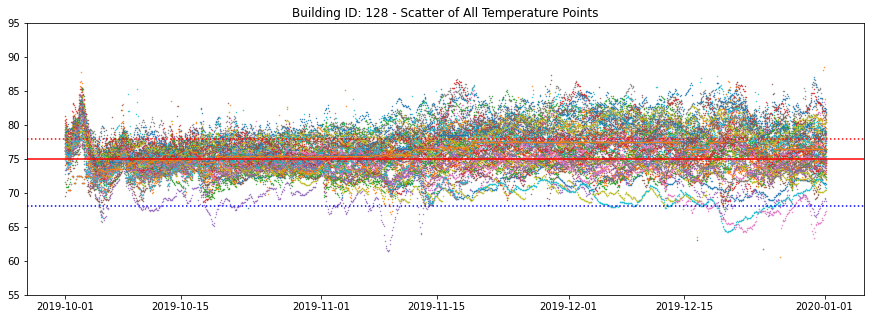

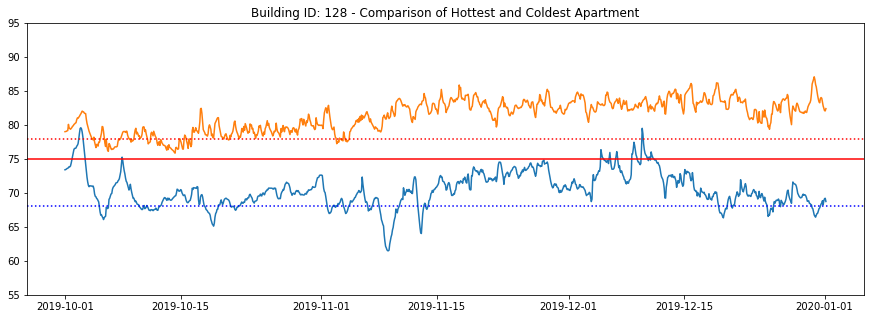

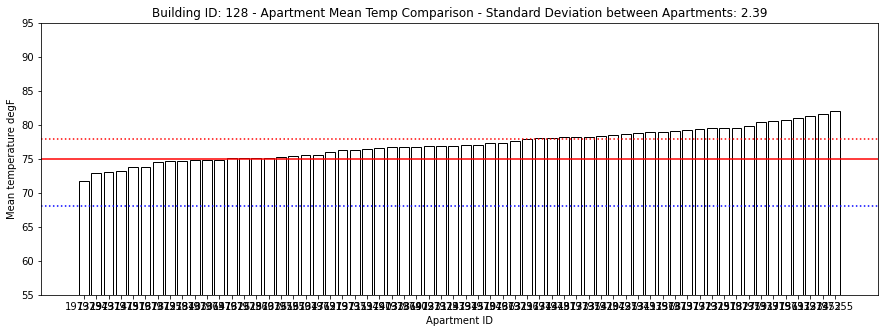

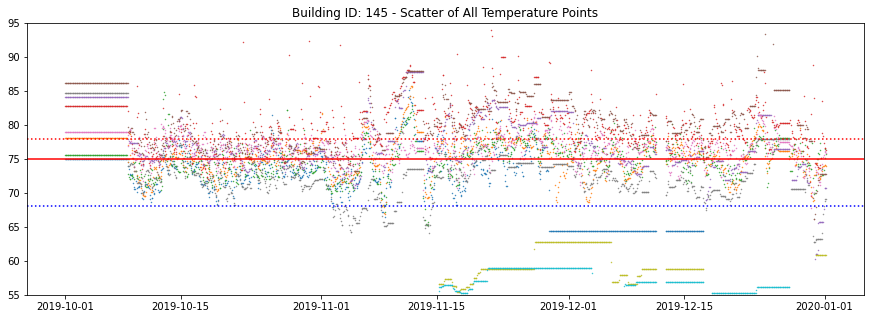

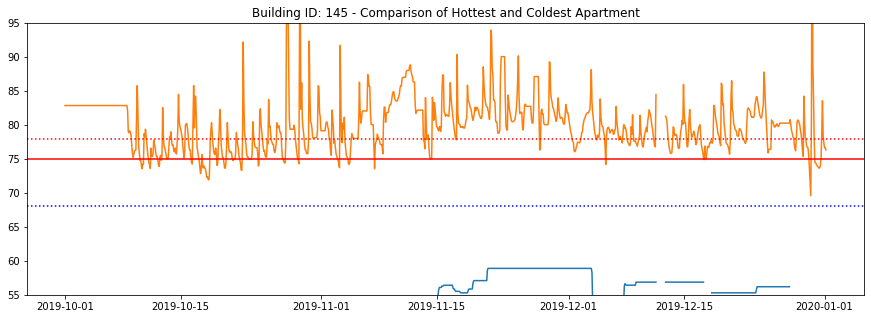

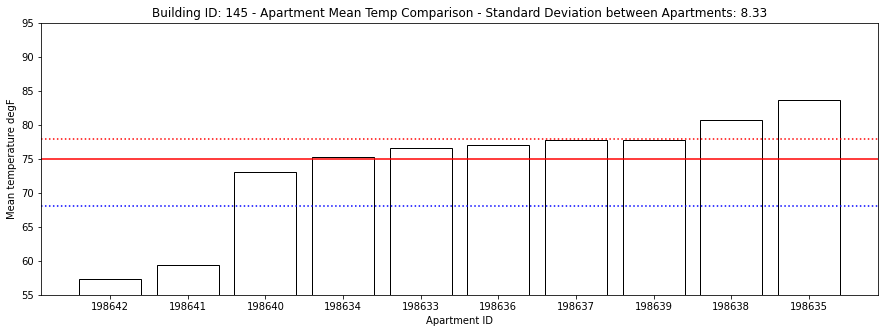

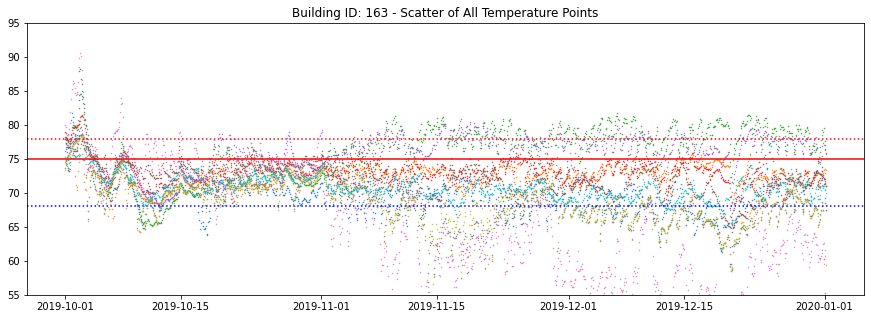

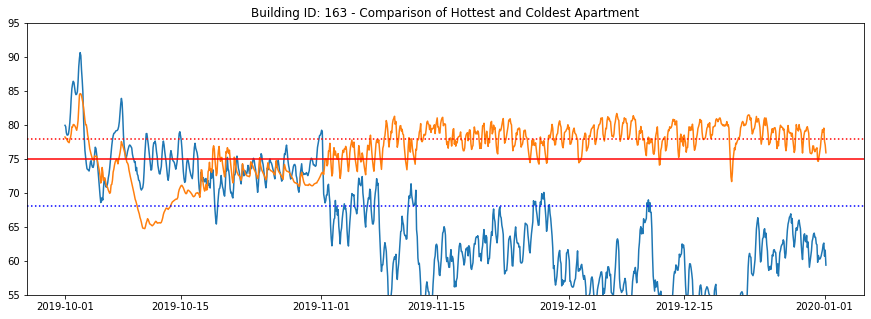

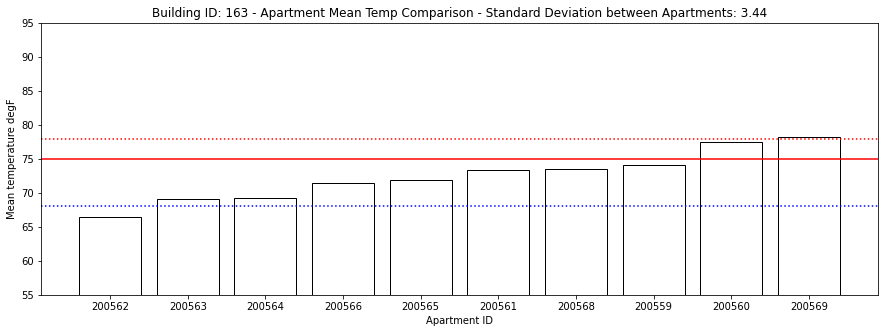

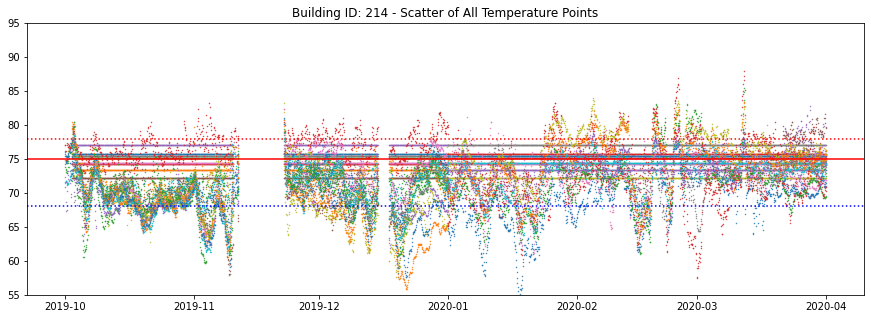

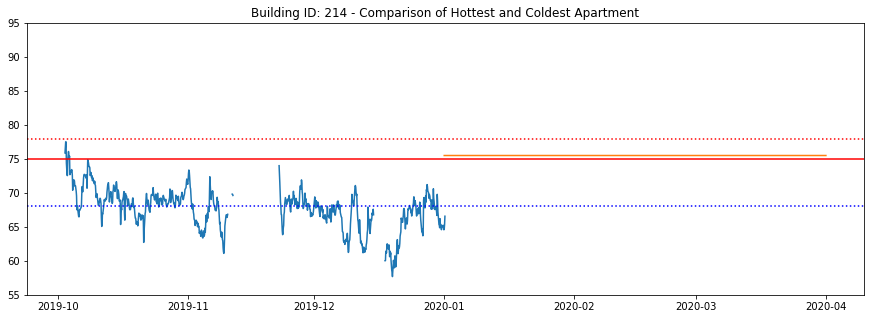

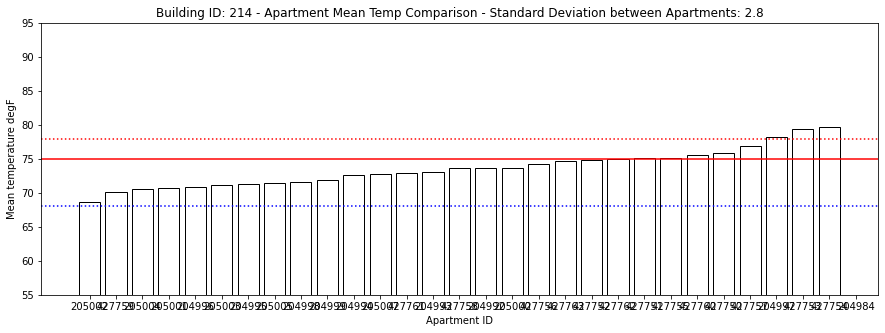

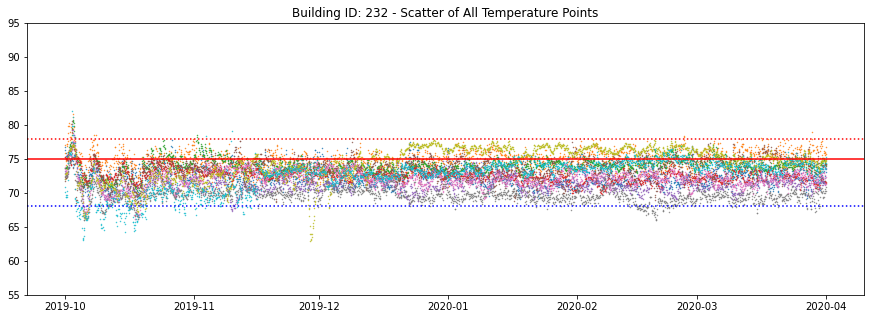

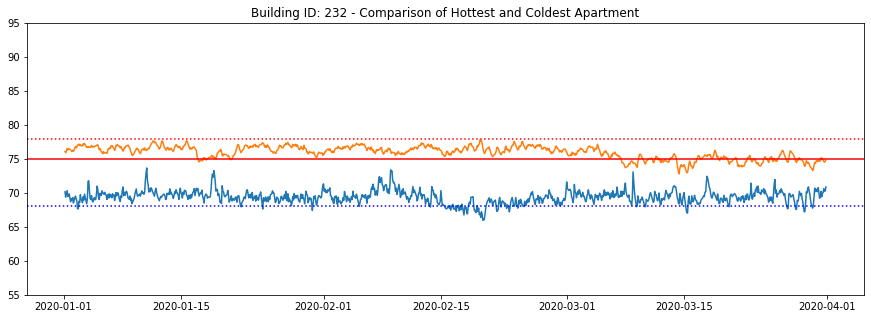

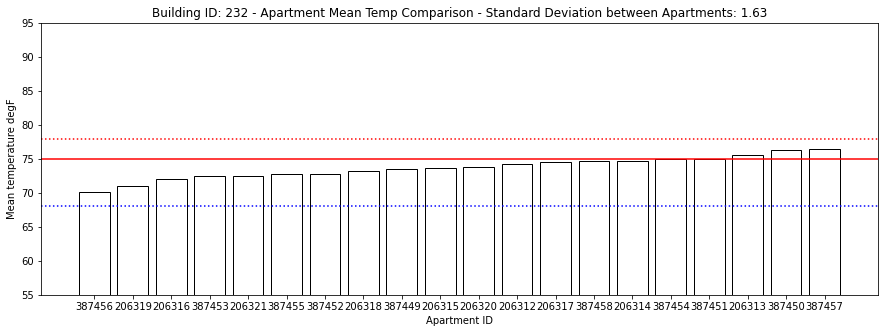

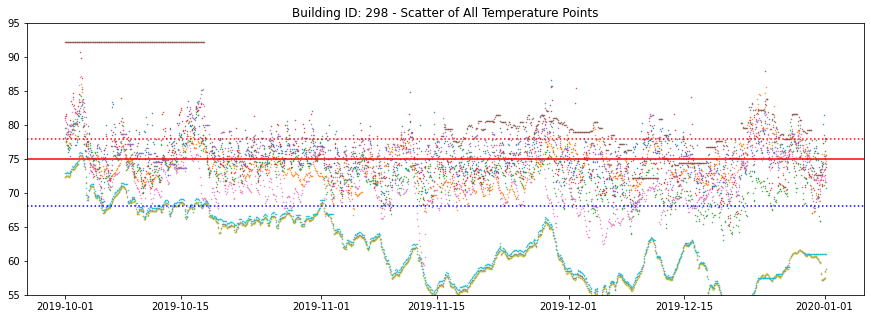

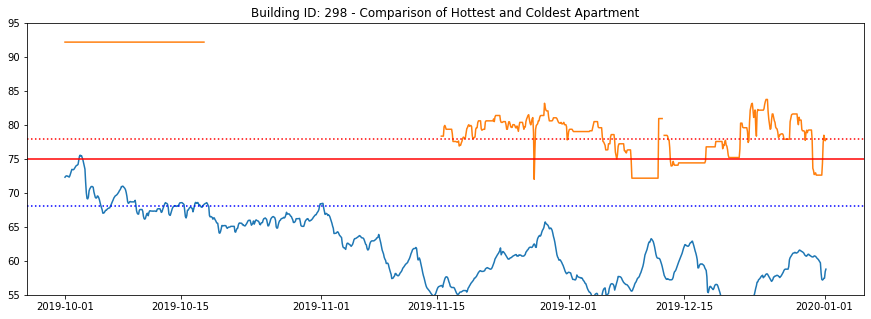

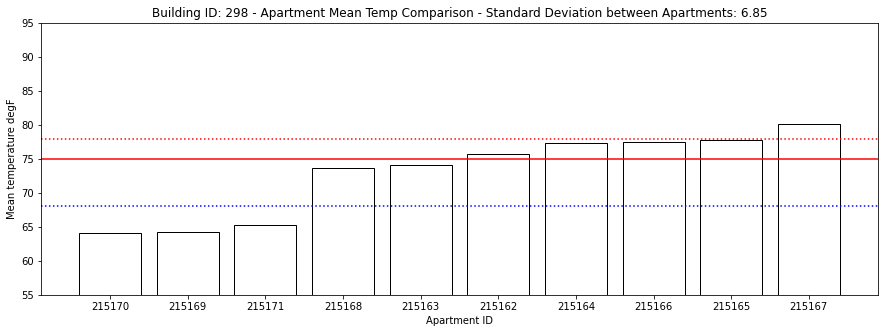

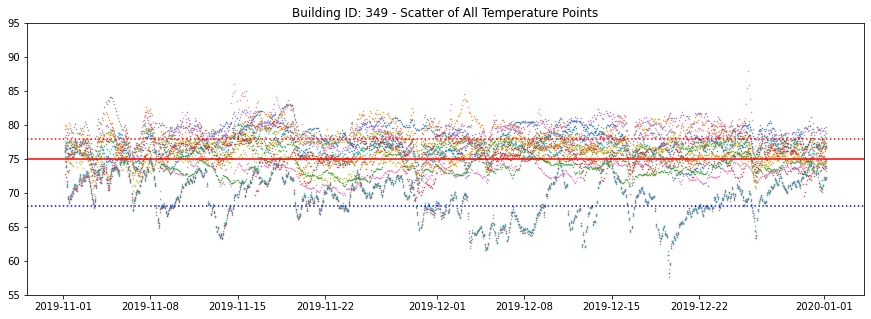

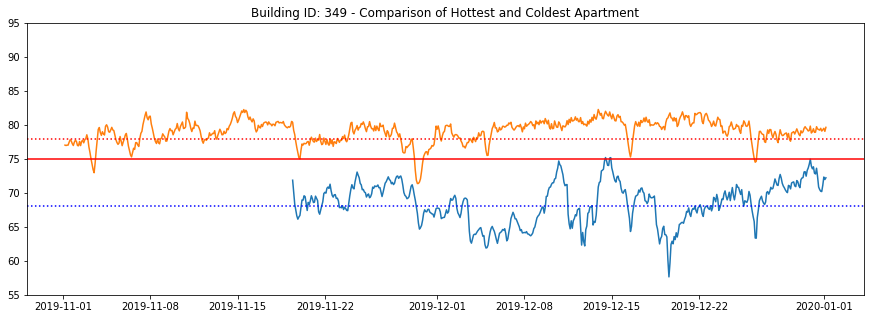

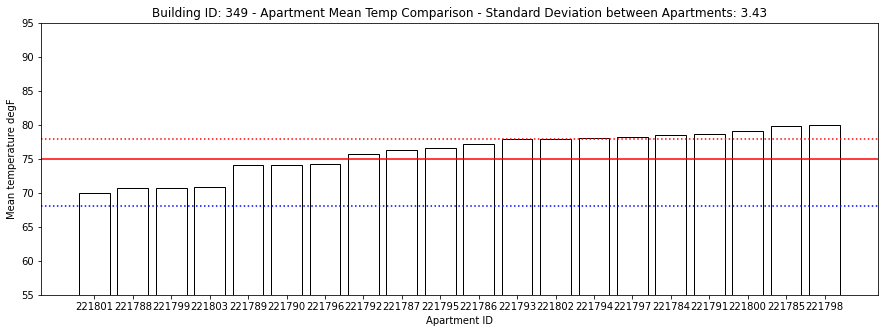

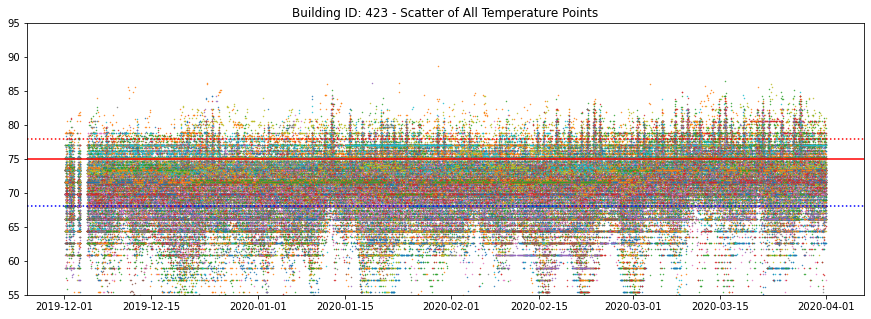

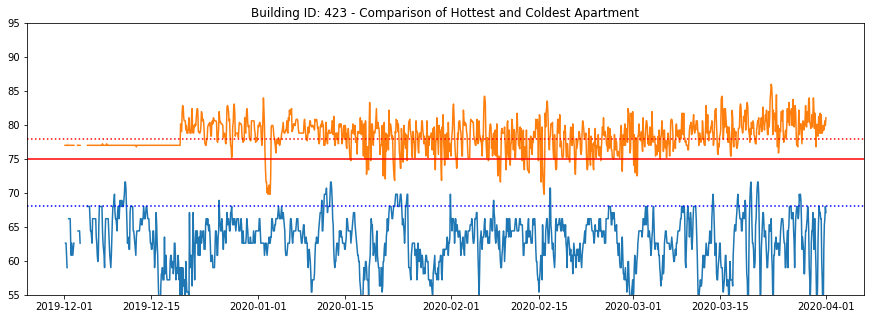

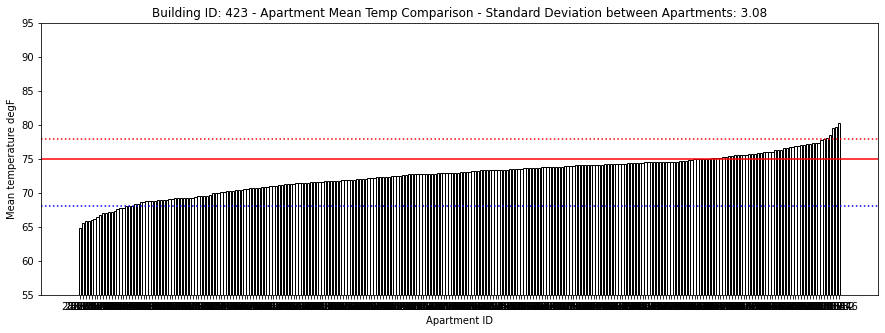

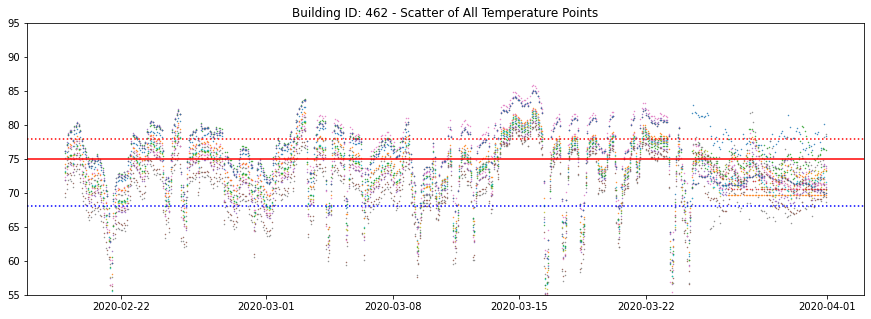

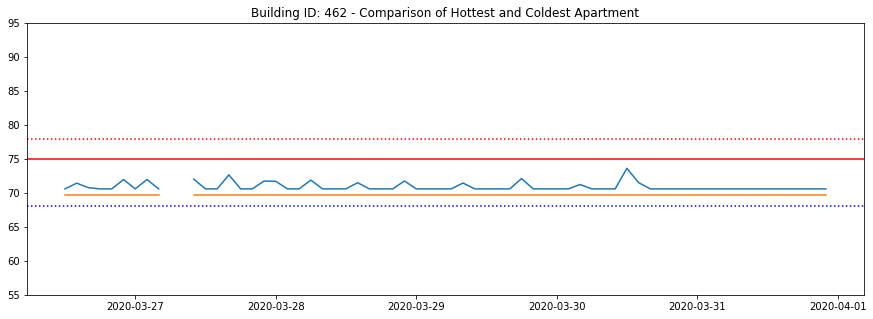

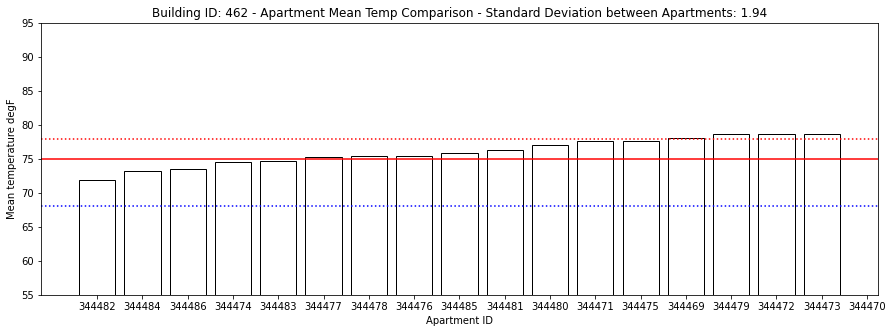

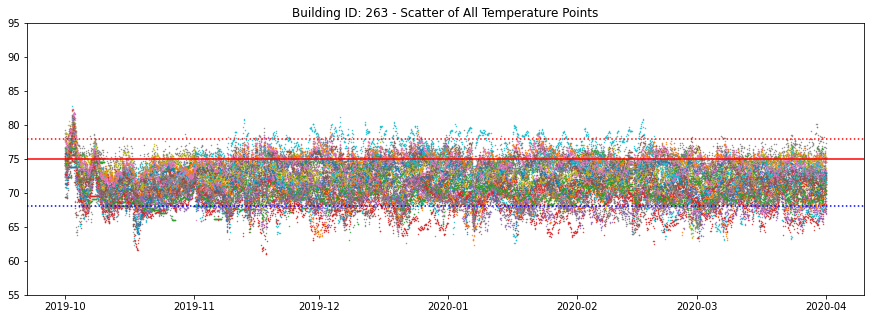

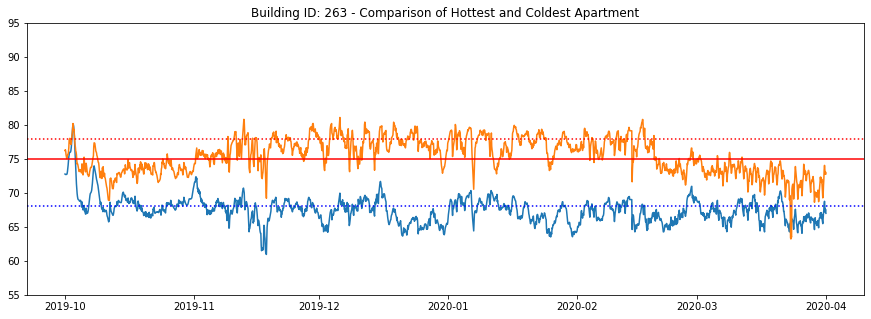

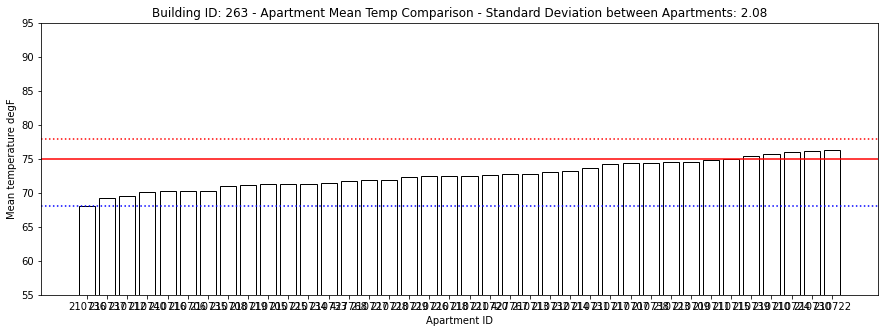

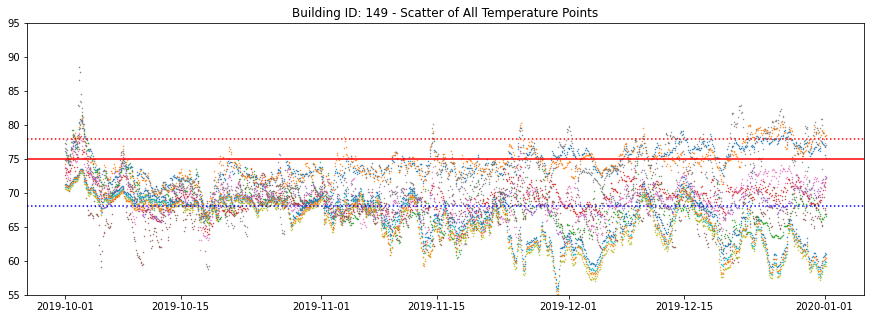

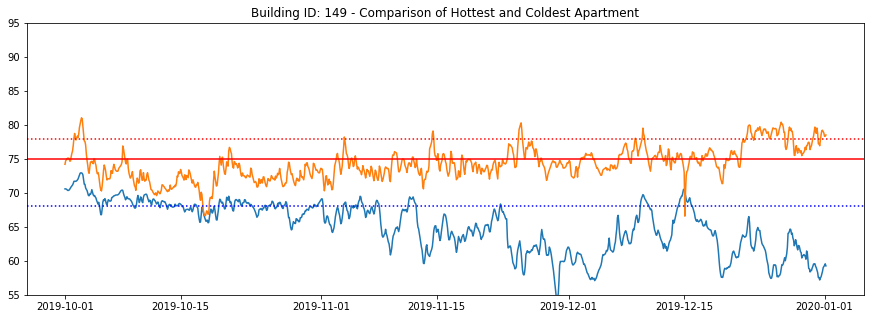

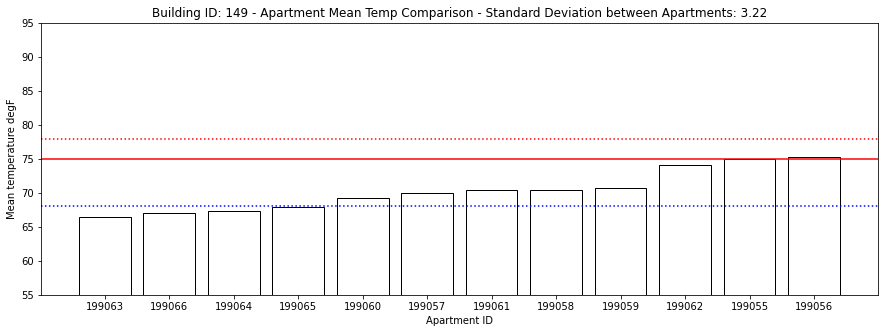

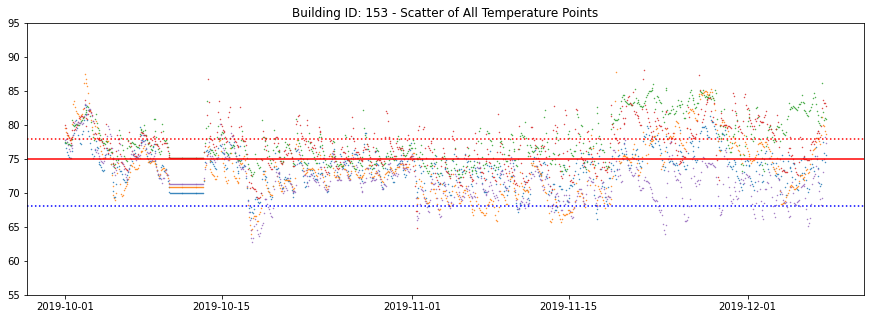

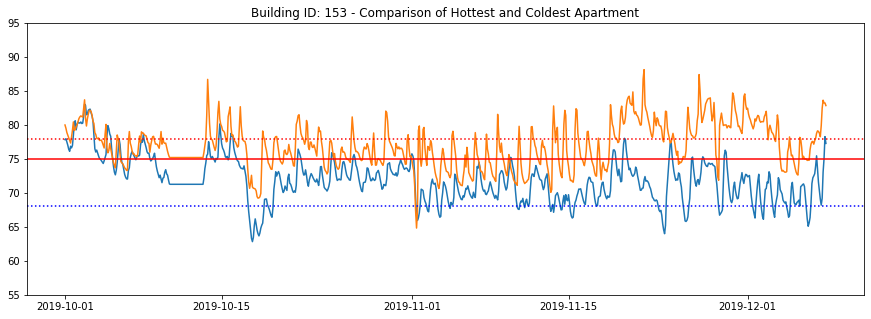

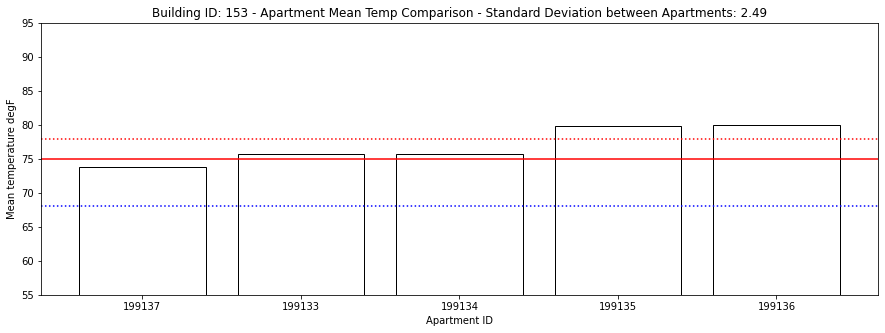

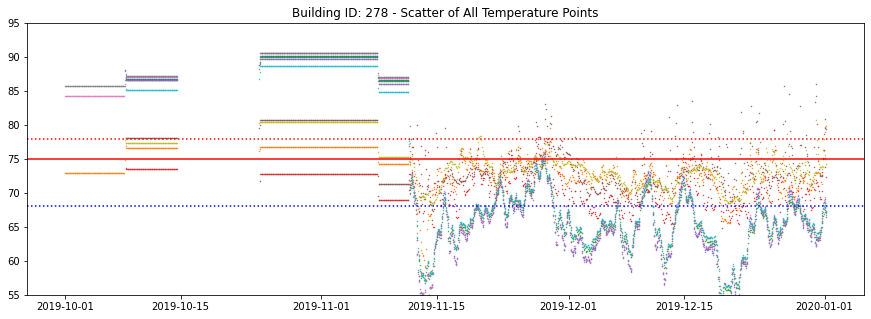

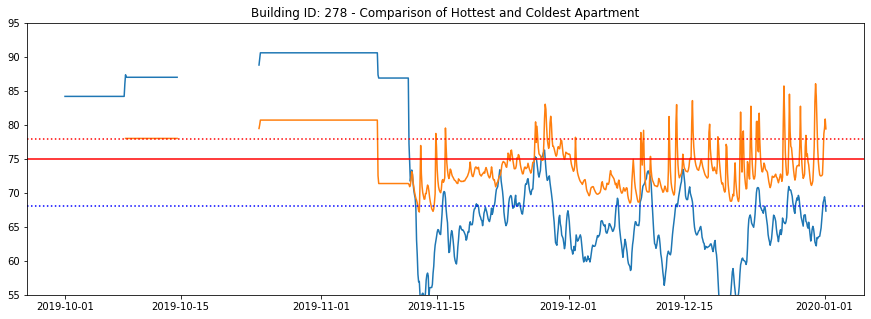

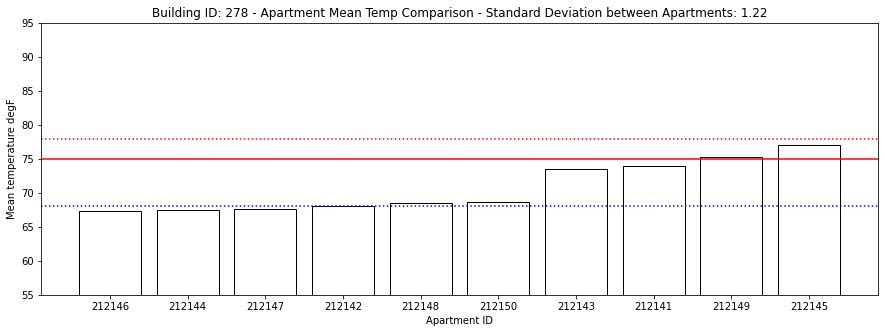

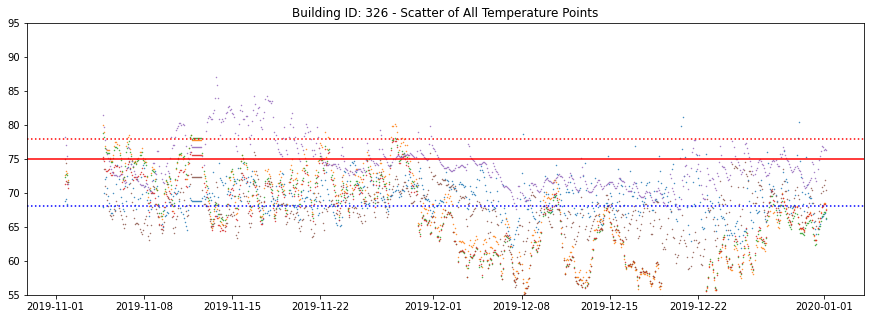

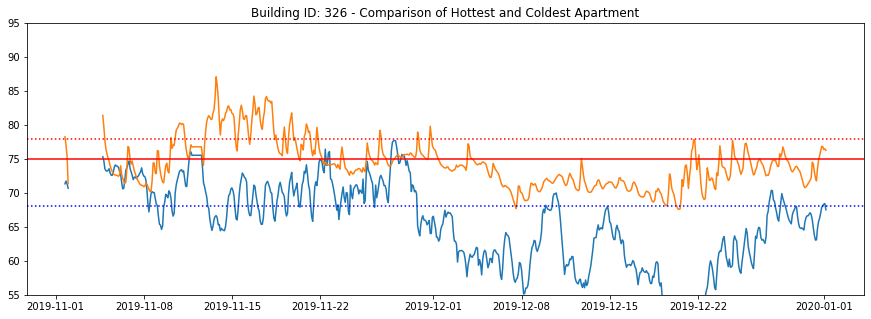

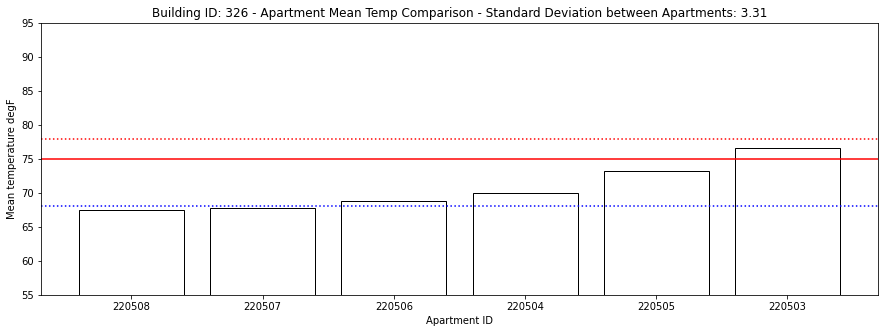

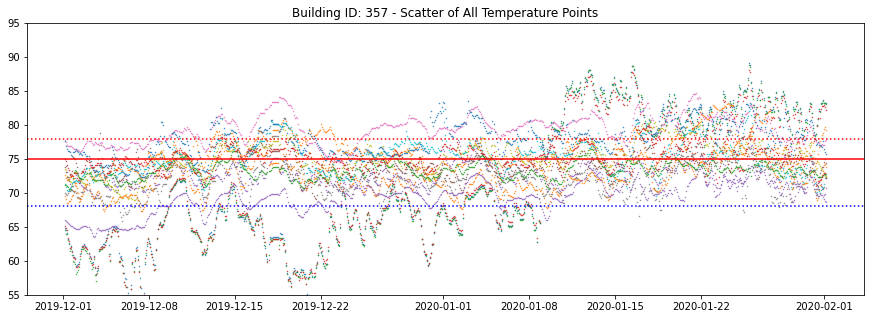

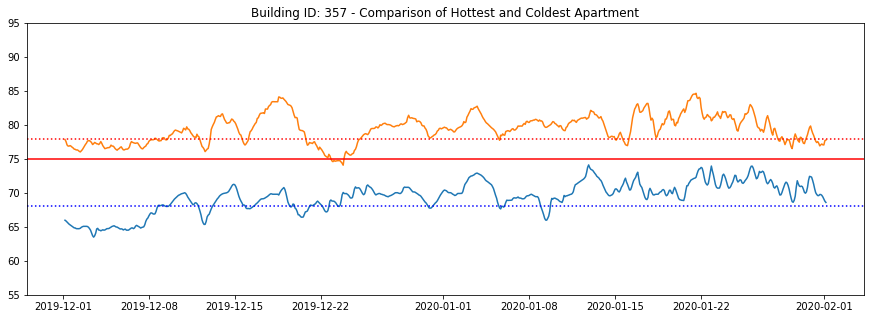

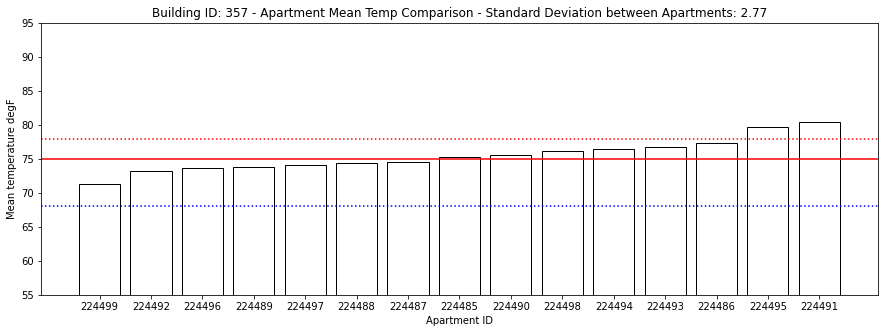

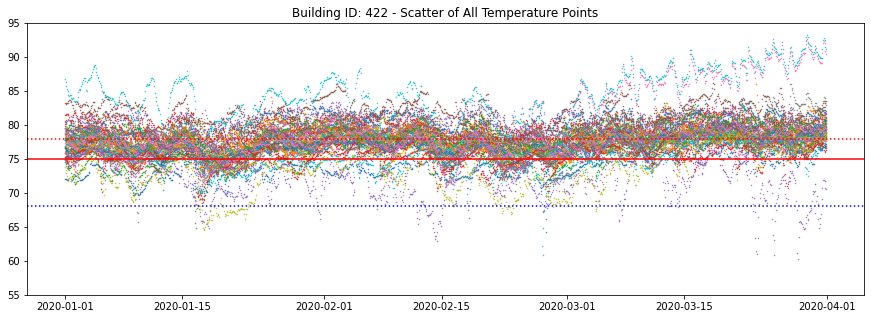

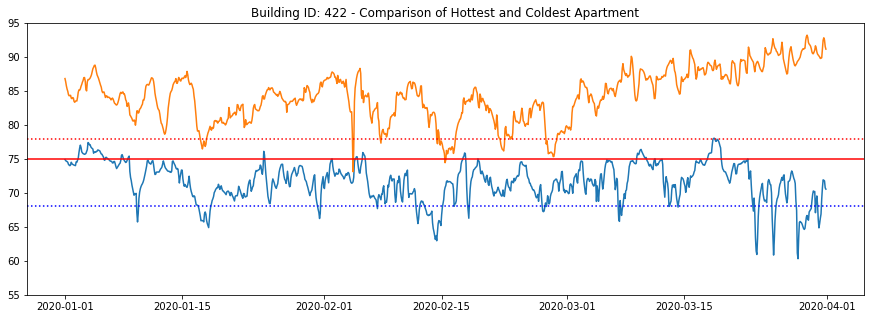

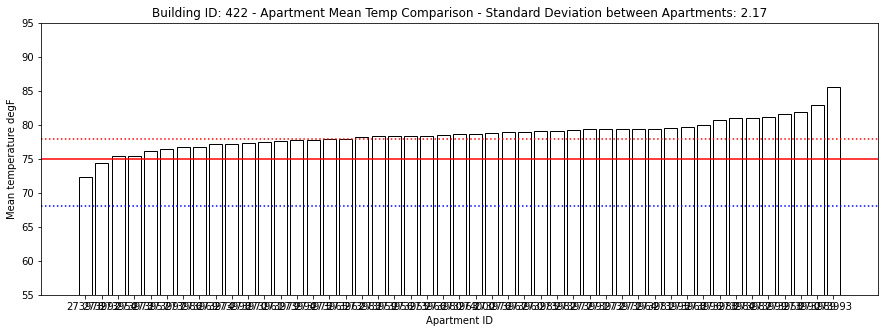

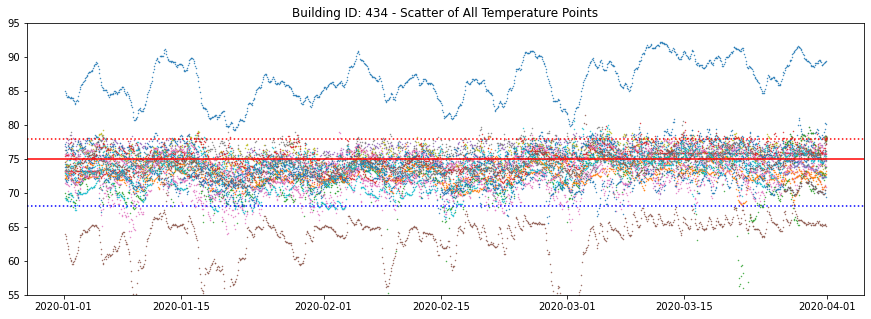

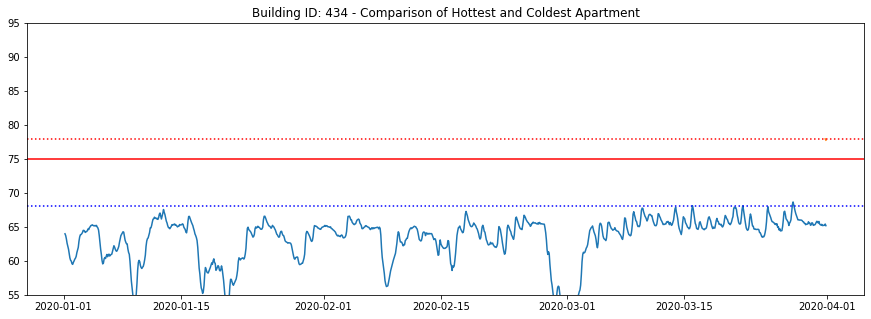

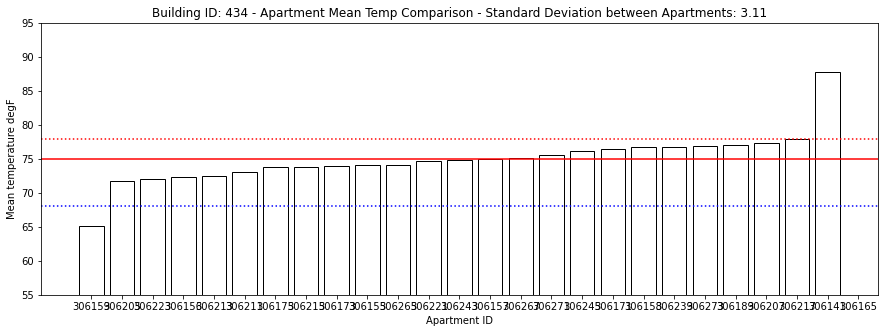

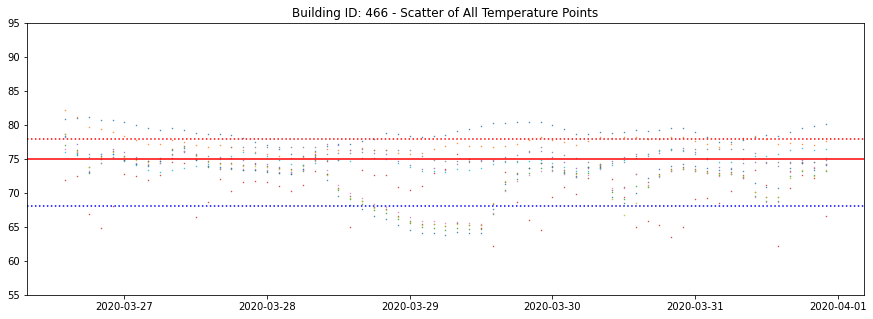

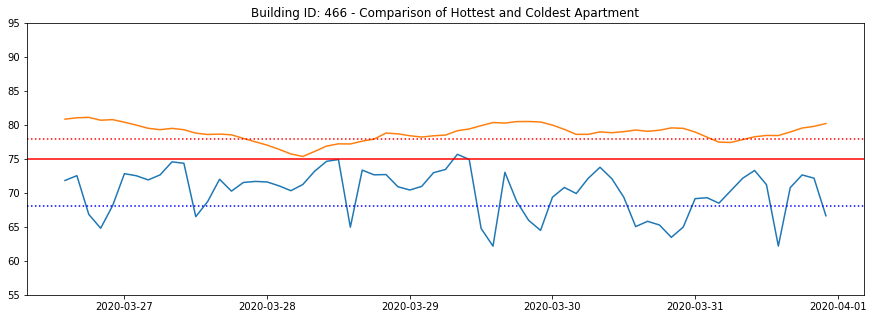

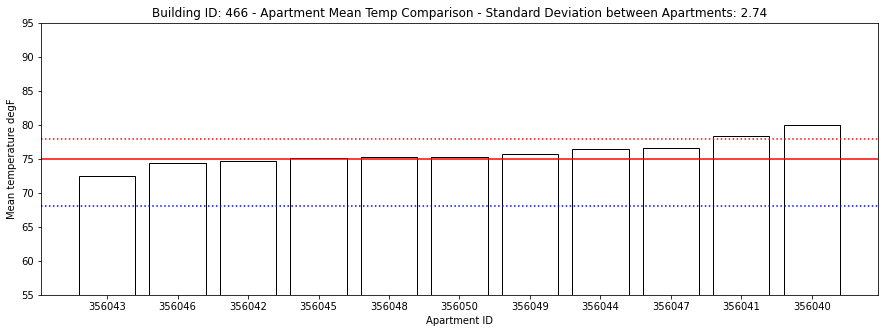

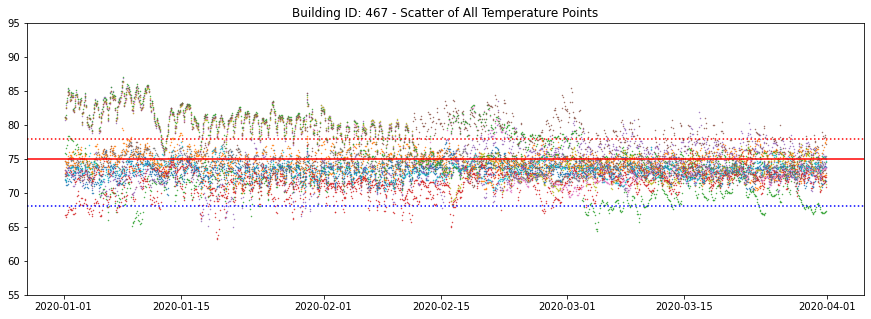

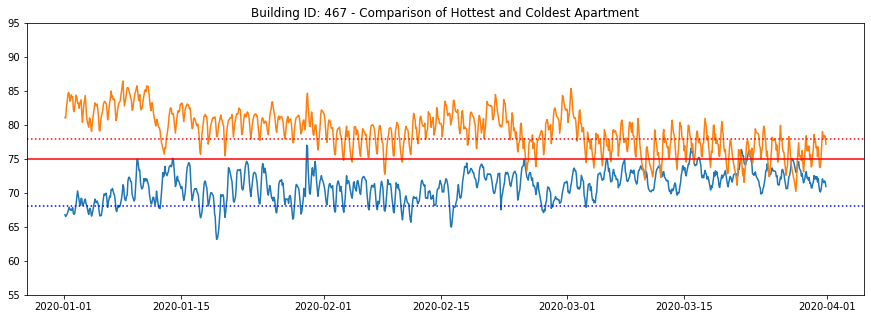

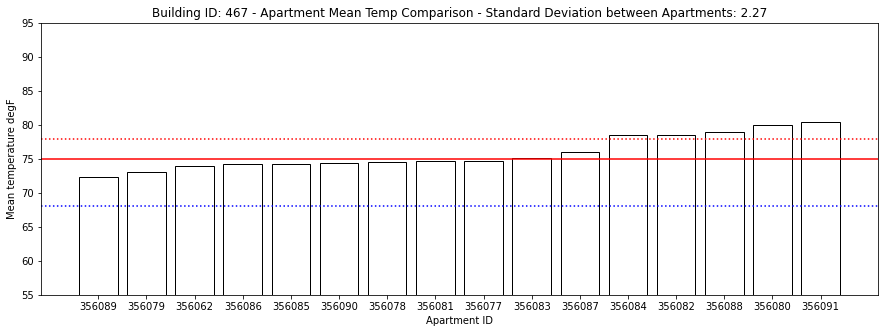

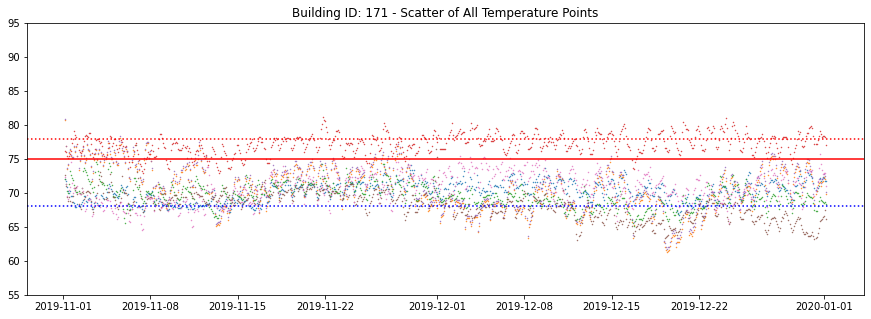

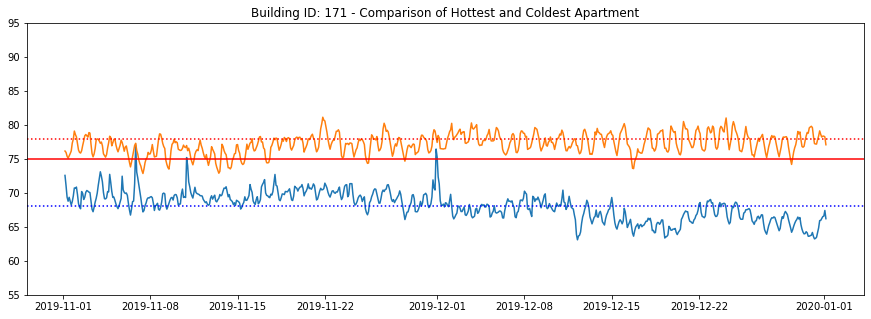

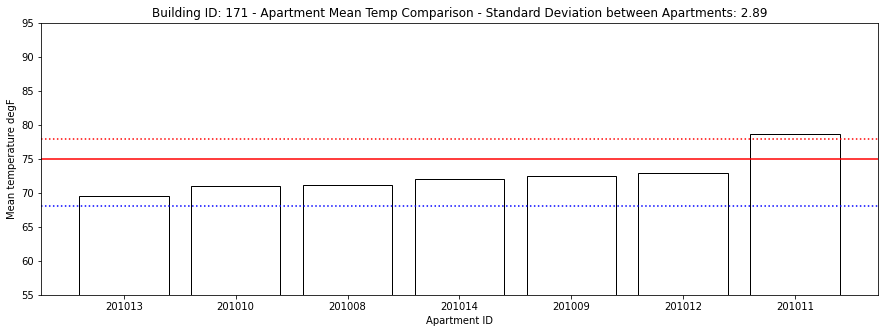

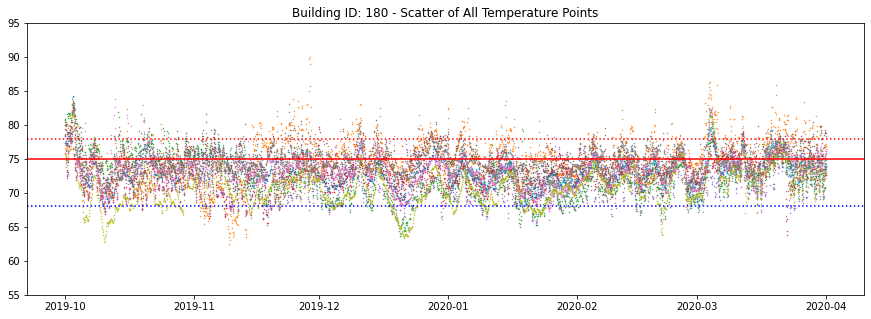

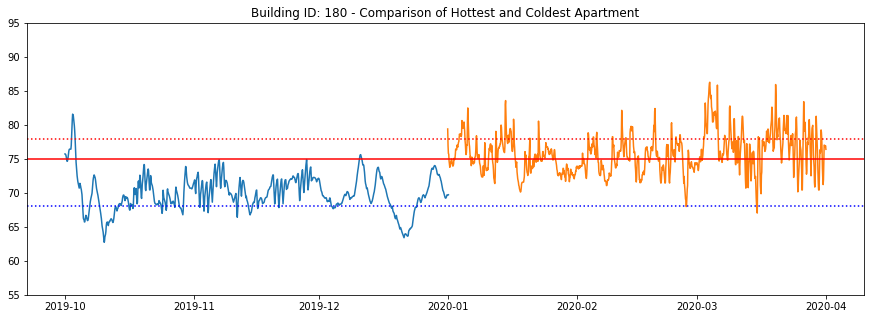

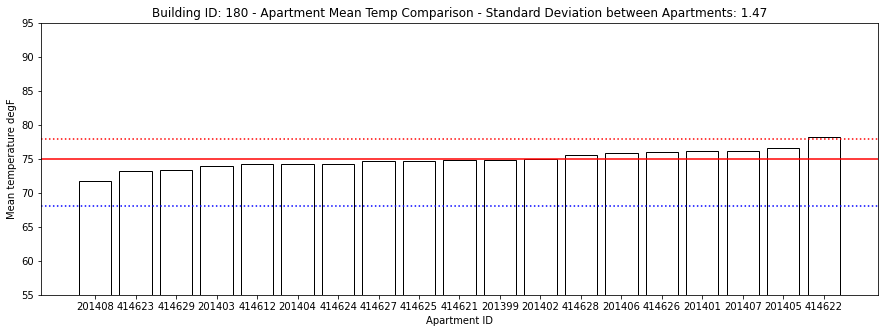

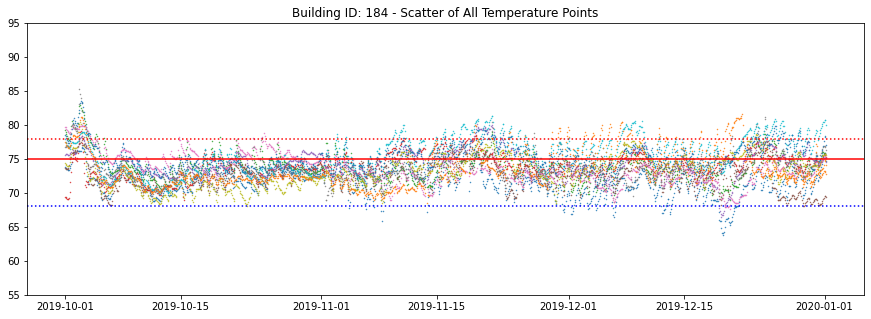

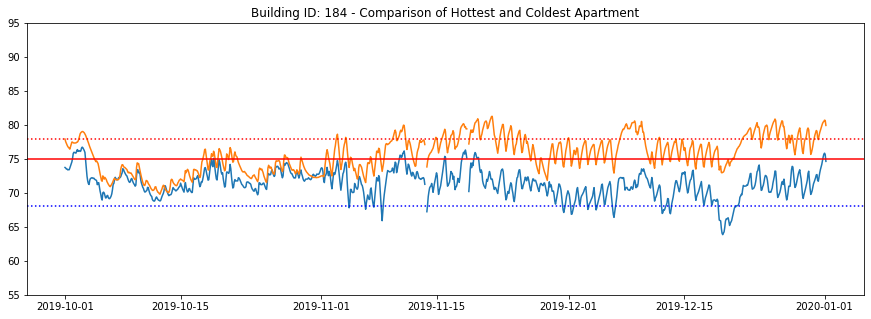

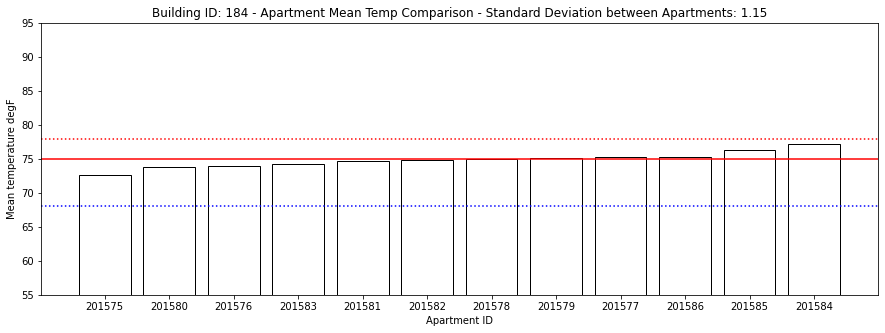

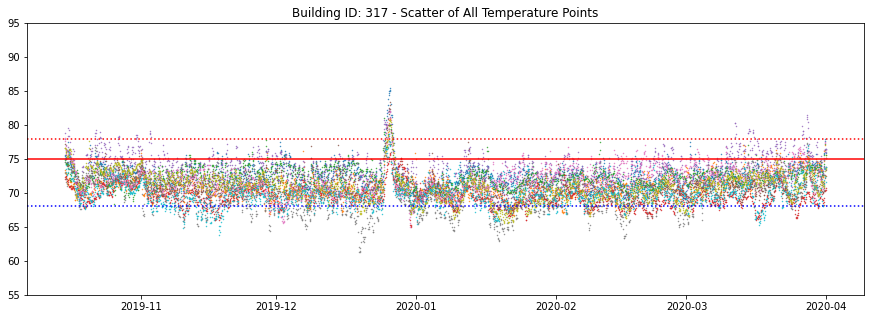

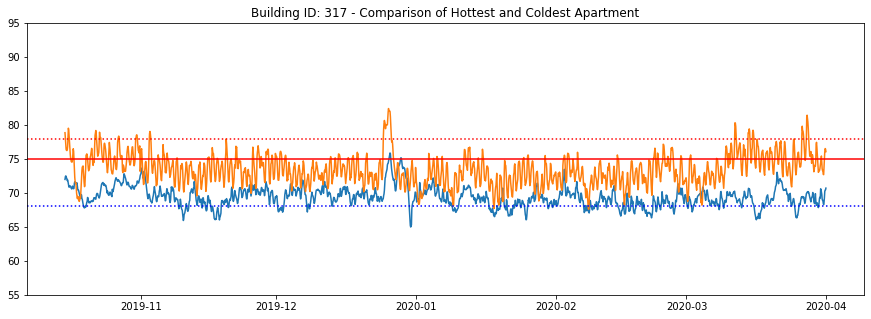

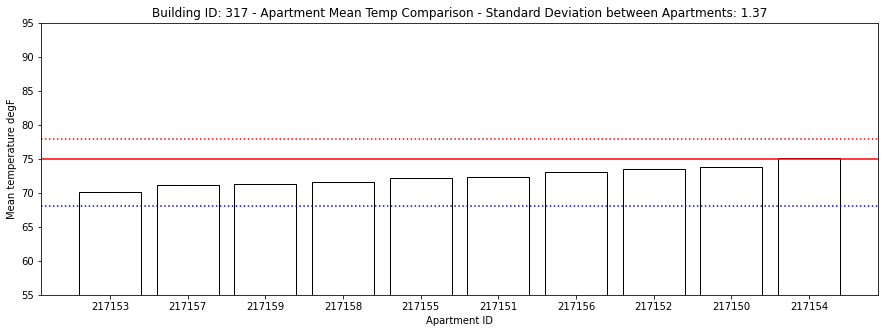

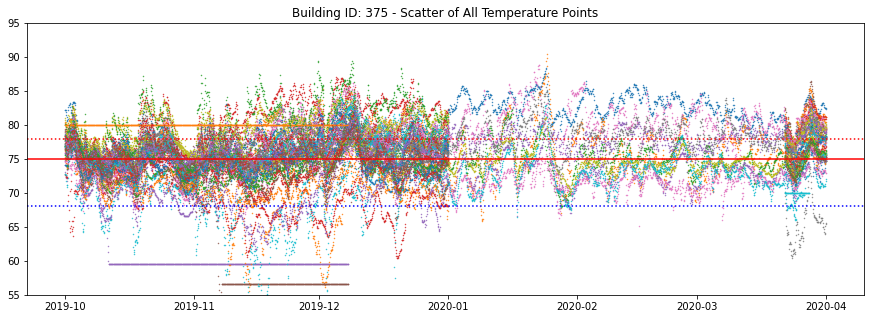

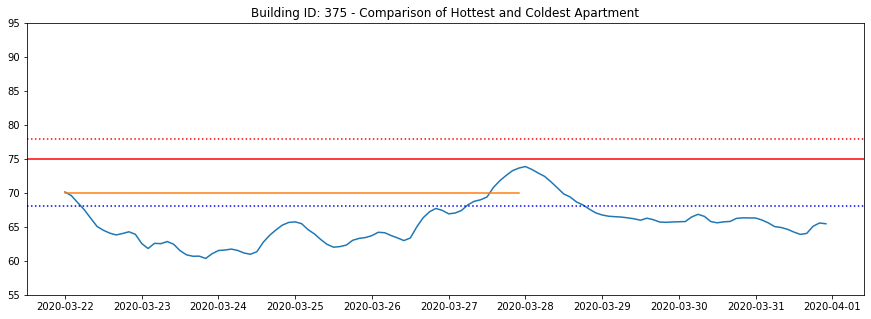

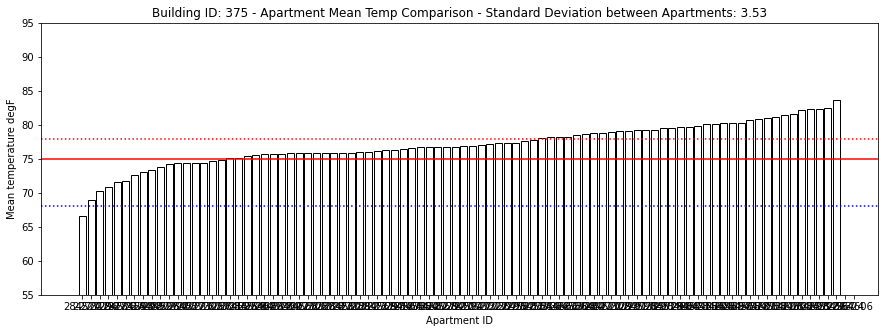

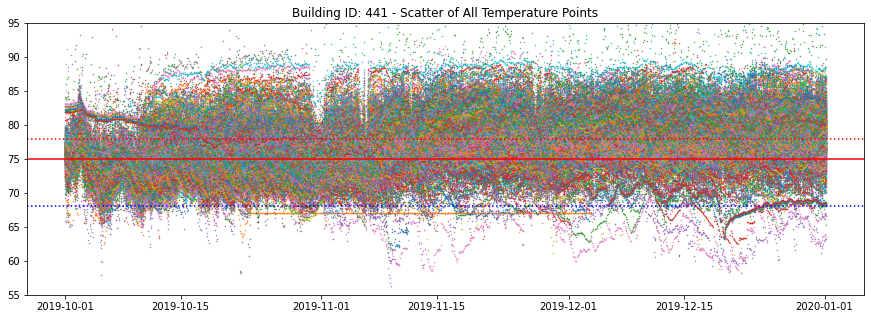

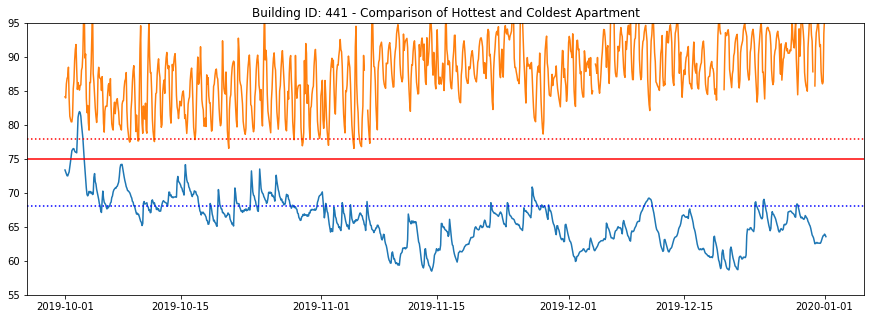

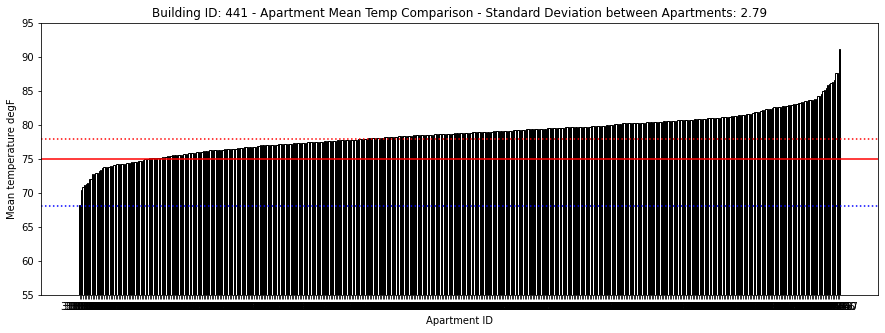

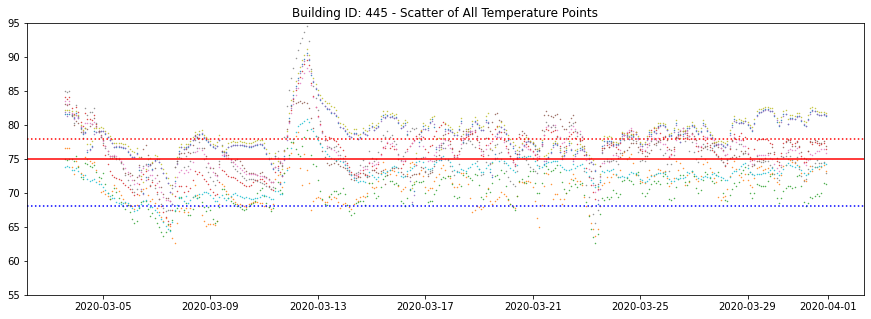

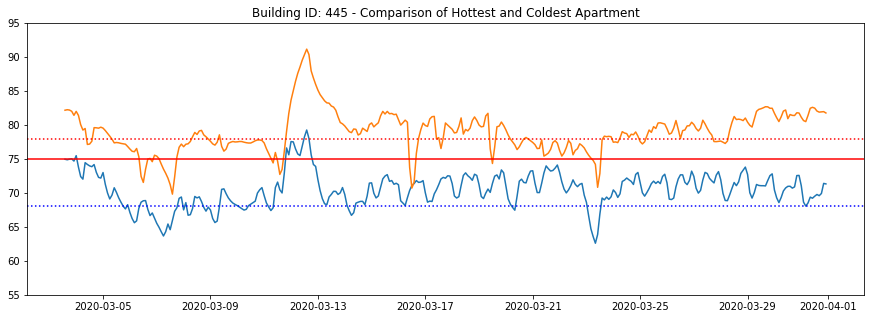

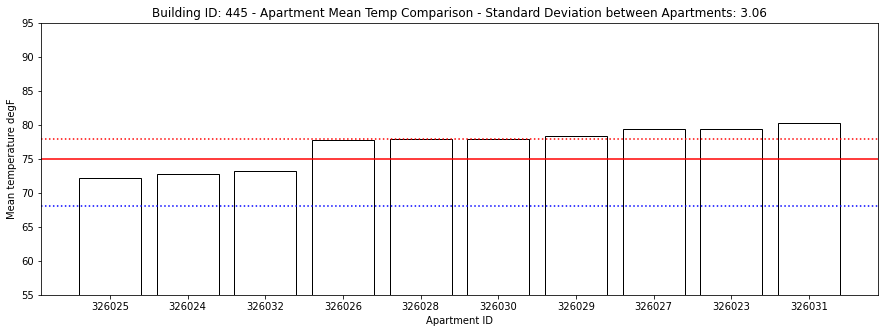

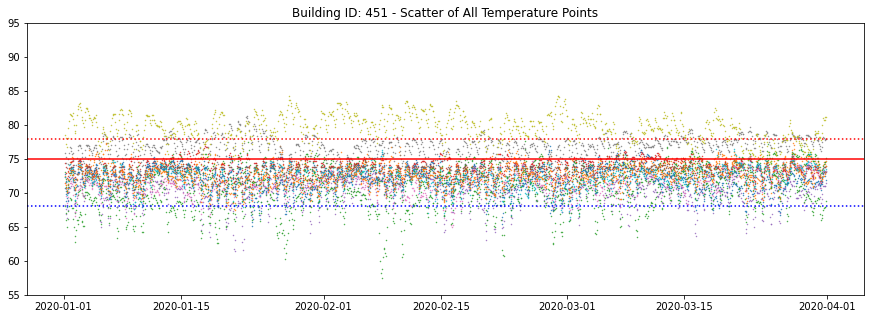

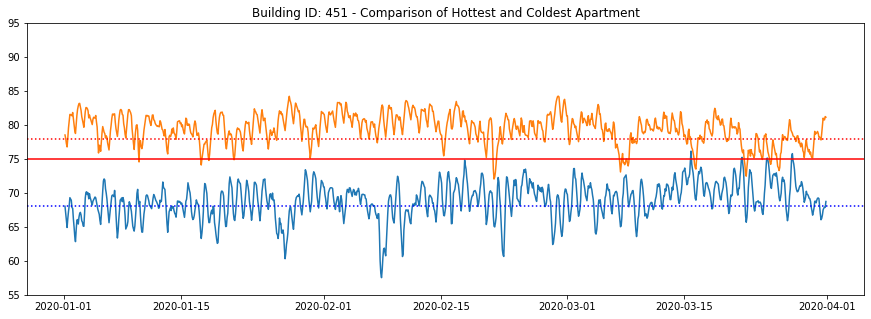

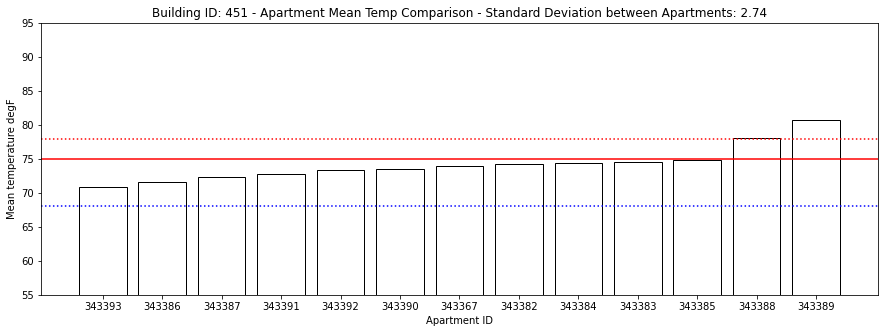

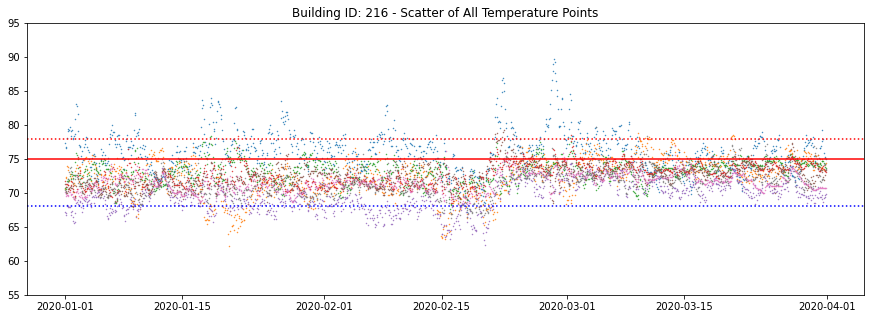

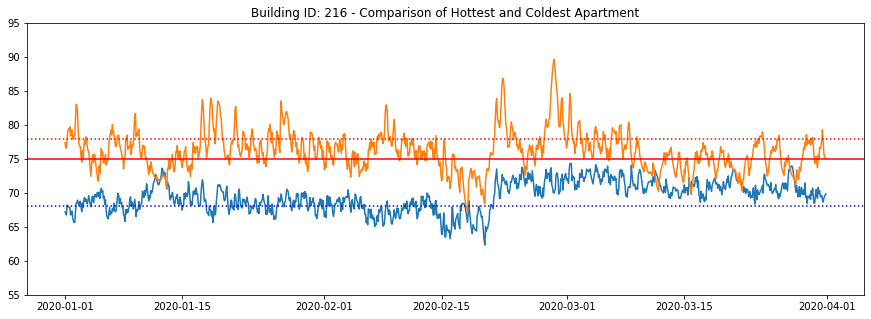

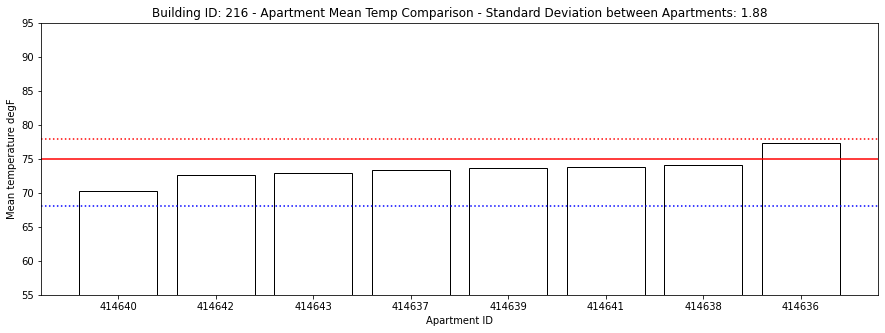

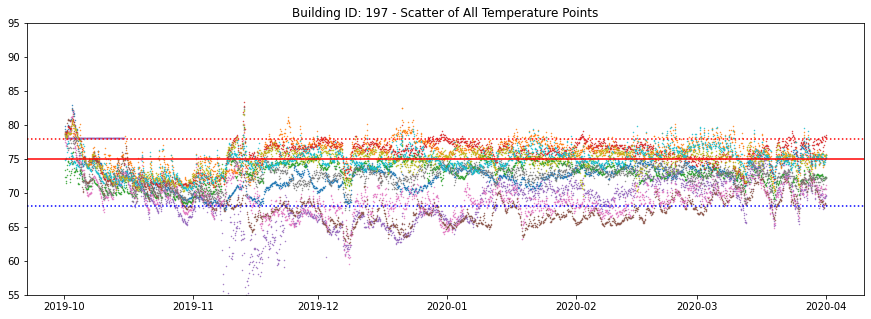

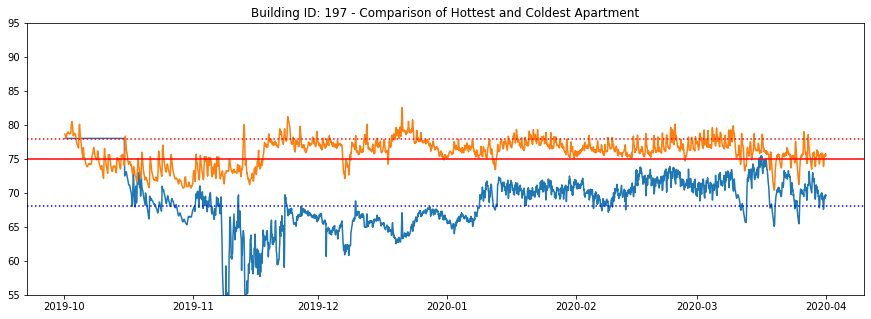

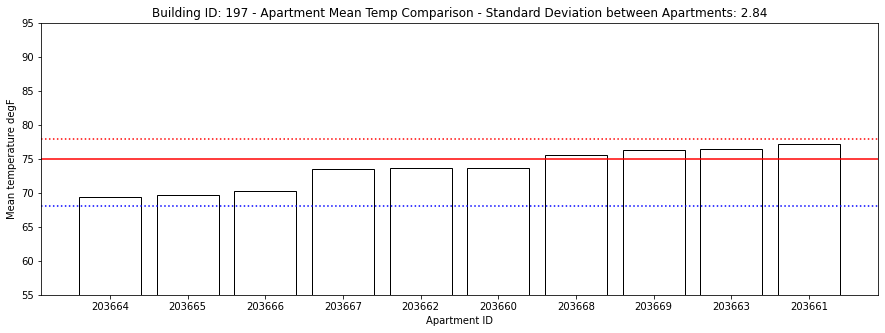

In [26]:
list_of_stds = []
count = 0
for b_id in sensor_metadata.building_id.unique():
#     print(b_id)
    metadata_subset = sensor_metadata.loc[sensor_metadata['building_id'] == b_id]
    zone_temps_subset = zone_temps[metadata_subset['id_str']]
    zone_temps_subset = zone_temps_subset.reset_index()
    
    subset_resampled = zone_temps_subset.resample('120min', on="timestamp").mean()
    subset_peaks = subset_resampled.copy()
    subset_peaks.loc[:] = np.NaN
    subset_troughs = subset_resampled.copy()
    subset_troughs.loc[:] = np.NaN
    
    for i in range(subset_resampled.shape[1]):
        signal = subset_resampled.iloc[:,i].fillna(subset_resampled.iloc[:,i].mean())
        
        peak_idx = find_peaks(signal, prominence=.5)[0]
        subset_peaks.iloc[peak_idx, i] = subset_resampled.iloc[peak_idx, i]
        
        peak_idx = find_peaks(-signal, prominence=.5)[0]
        subset_troughs.iloc[peak_idx, i] = subset_resampled.iloc[peak_idx, i]
    
    std_val = round(subset_resampled.mean().std(),2)
    list_of_stds.append(std_val)
    
    if round(subset_peaks.mean().std(),2)-round(subset_troughs.mean().std(),2) < 0:
        count+=1
    
    plt.figure(figsize=[15,5])
    plt.title('Building ID: ' + str(b_id) + ' - Scatter of All Temperature Points')
    
    for i in range(subset_peaks.shape[1]):
#         plt.scatter(subset_peaks.index, subset_peaks.iloc[:,i], s=1.2)
        plt.scatter(subset_resampled.index, subset_resampled.iloc[:,i], s=.2)

    plt.axhline(y=78, color='r', linestyle=':')
    plt.axhline(y=75, color='r', linestyle='-')
    plt.axhline(y=68, color='b', linestyle=':')
    plt.ylim([55,95])
    
#     mean_temp_ids = subset_resampled.mean().sort_values().index
#     mean_temp_values = subset_resampled.mean().sort_values().values

    mean_temp_ids = subset_peaks.mean().sort_values().index
    mean_temp_values = subset_peaks.mean().sort_values().values
    
    
#     break
    
    plt.figure(figsize=[15,5])
    plt.title('Building ID: ' + str(b_id) + ' - Comparison of Hottest and Coldest Apartment')
    plt.plot(subset_resampled[mean_temp_ids[0]].index, subset_resampled[mean_temp_ids[0]])
#     plt.scatter(subset_peaks[mean_temp_ids[0]].index, subset_peaks[mean_temp_ids[0]])
    
    plt.plot(subset_resampled[mean_temp_ids[-1]].index, subset_resampled[mean_temp_ids[-1]])
#     plt.scatter(subset_peaks[mean_temp_ids[-1]].index, subset_peaks[mean_temp_ids[-1]])
    plt.ylim([55,95])
    plt.axhline(y=78, color='r', linestyle=':')
    plt.axhline(y=75, color='r', linestyle='-')
    plt.axhline(y=68, color='b', linestyle=':')
    
    plt.figure(figsize=[15,5])
    plt.bar(mean_temp_ids,mean_temp_values, fill=False)
    plt.ylim([55,95])
    plt.axhline(y=78, color='r', linestyle=':')
    plt.axhline(y=75, color='r', linestyle='-')
    plt.axhline(y=68, color='b', linestyle=':')
    plt.ylabel('Mean temperature degF')
    plt.xlabel('Apartment ID')
    plt.title('Building ID: ' + str(b_id) + ' - Apartment Mean Temp Comparison - Standard Deviation between Apartments: ' + str(std_val))
    plt.plot()
    plt.show()
#     break

std against outdoor temp

boiler data for something

Taking a look at building 441 for first order decay...

In [77]:
query = PointSelector()
query.point_types = ['Zone Temperature', 'Outside Air Temperature', 'Steam Temperature']
query.buildings = [441]
selection = client.select_points(query)

In [78]:
sensor_metadata = pd.DataFrame(client.get_points_by_ids(selection['points']))

In [79]:
sensor_metadata['type'].unique()

array(['Zone Temperature', 'Outside Air Temperature'], dtype=object)

In [80]:
sensor_metadata['type'].value_counts()

Zone Temperature           940
Outside Air Temperature      3
Name: type, dtype: int64

In [81]:
sensor_metadata[sensor_metadata['type'] == 'Outside Air Temperature']['name'][1]

'225 E 149th St. Controller [Tekmar 284] Outdoor Air Temperature [BAS]'

In [82]:
start = datetime(2019, 10, 1, 0, 0, 0, 0, pytz.UTC)
end   = datetime(2020, 4, 1, 0, 0, 0, 0, pytz.UTC)

timeseries_query = TimeseriesQuery(point_ids = selection['points'], start = start, end = end)
sensor_data = points_df_from_streaming_timeseries(client.stream_point_timeseries(timeseries_query))

In [83]:
sensor_data['timestamp'] = pd.to_datetime(sensor_data['timestamp'])

In [84]:
sensor_data['timestamp'] = sensor_data['timestamp'].dt.tz_convert('US/Eastern')

In [85]:
sensor_data = sensor_data.set_index('timestamp')

In [86]:
name_for_col = []
for id in sensor_data.columns:
    name_for_col.append(sensor_metadata[sensor_metadata['id'] == id]['name'].values[0])

In [87]:
len(name_for_col)

469

In [88]:
len(sensor_data.columns)

469

In [89]:
sensor_data.columns = name_for_col

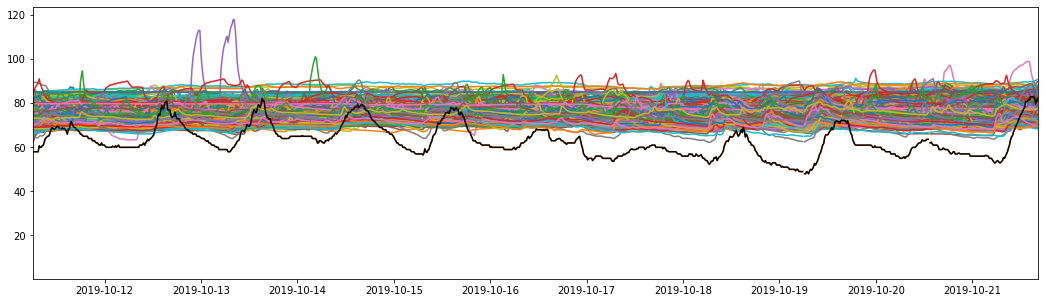

In [94]:
plt.figure(figsize=[18,5])
plt.plot(sensor_data.index, sensor_data)
plt.plot(sensor_data.index, sensor_data['245 E 149th St. Controller [Tekmar 284] Outdoor Air Temperature'], color='black')
# The latter outside air temp is trashhhh
plt.xlim([sensor_data.index[1000], sensor_data.index[2000]])
plt.show()

In [96]:
sensor_data.iloc[:,0]

timestamp
2019-09-30 20:15:00-04:00    80.674998
2019-09-30 20:30:00-04:00    81.050001
2019-09-30 20:45:00-04:00    81.237495
2019-09-30 21:00:00-04:00    81.387497
2019-09-30 21:15:00-04:00    81.387497
                               ...    
2019-12-31 22:45:00-05:00    77.974996
2019-12-31 23:00:00-05:00    77.899994
2019-12-31 23:15:00-05:00    77.750000
2019-12-31 23:30:00-05:00    77.618752
2019-12-31 23:45:00-05:00    77.449997
Name: 255 E 149th St. Floor-11 Apt-11E Zone Zone Temperature, Length: 8829, dtype: float64

In [99]:
sensor_data_no_na = sensor_data.dropna()

In [100]:
sensor_data_no_na['245 E 149th St. Controller [Tekmar 284] Outdoor Air Temperature'].corr(sensor_data_no_na.iloc[:,0])

0.14466491033130308

In [112]:
list_of_corr = []
list_of_col = []
for col in sensor_data_no_na.columns:
    corr = sensor_data_no_na['245 E 149th St. Controller [Tekmar 284] Outdoor Air Temperature'].corr(sensor_data_no_na[col])
    list_of_col.append(col)
    list_of_corr.append(corr)

In [113]:
df = pd.DataFrame({'Name':list_of_col, 'Corr': list_of_corr})
df

Name      Corr
0    255 E 149th St. Floor-11 Apt-11E Zone Zone Tem...  0.144665
1    225 E 149th St. Floor-03 Apt-03A Zone Zone Tem... -0.216743
2    225 E 149th St. Floor-03 Apt-03B Zone Zone Tem...  0.110939
3    225 E 149th St. Floor-03 Apt-03C Zone Zone Tem... -0.495604
4    225 E 149th St. Floor-03 Apt-03D Zone Zone Tem... -0.362842
..                                                 ...       ...
464  255 E 149th St. Floor-10 Apt-10E Zone Zone Tem... -0.265037
465  255 E 149th St. Floor-11 Apt-11A Zone Zone Tem... -0.643794
466  255 E 149th St. Floor-11 Apt-11B Zone Zone Tem... -0.533532
467  255 E 149th St. Floor-11 Apt-11C Zone Zone Tem... -0.024139
468  255 E 149th St. Floor-11 Apt-11D Zone Zone Tem... -0.740627

[469 rows x 2 columns]

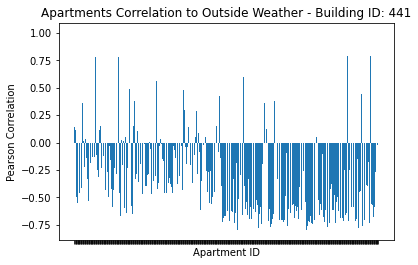

In [271]:
plt.bar(df['Name'],df['Corr'])
plt.xlabel('Apartment ID')
plt.ylabel('Pearson Correlation')
plt.title('Apartments Correlation to Outside Weather - Building ID: 441')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.show()

In [121]:
df.sort_values(by='Corr')[0:5]

Name      Corr
358  245 E 149th St. Floor-06 Apt-06E Zone Zone Tem... -0.799968
251  235 E 149th St. Floor-04 Apt-04G Zone Zone Tem... -0.799210
438  255 E 149th St. Floor-06 Apt-06D Zone Zone Tem... -0.778882
284  235 E 149th St. Floor-07 Apt-07E Zone Zone Tem... -0.778122
429  255 E 149th St. Floor-05 Apt-05G Zone Zone Tem... -0.777599

In [122]:
df.sort_values(by='Corr')[-7:-2]

Name      Corr
421  255 E 149th St. Floor-04 Apt-04L Zone Zone Tem...  0.786187
403  255 E 149th St. Floor-03 Apt-03A Zone Zone Tem...  0.786282
32   225 E 149th St. Floor-04 Apt-04R Zone Zone Tem...  0.786854
423  255 E 149th St. Floor-04 Apt-04P Zone Zone Tem...  0.787425
449  255 E 149th St. Floor-07 Apt-07C Zone Zone Tem...  0.846071

In [274]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

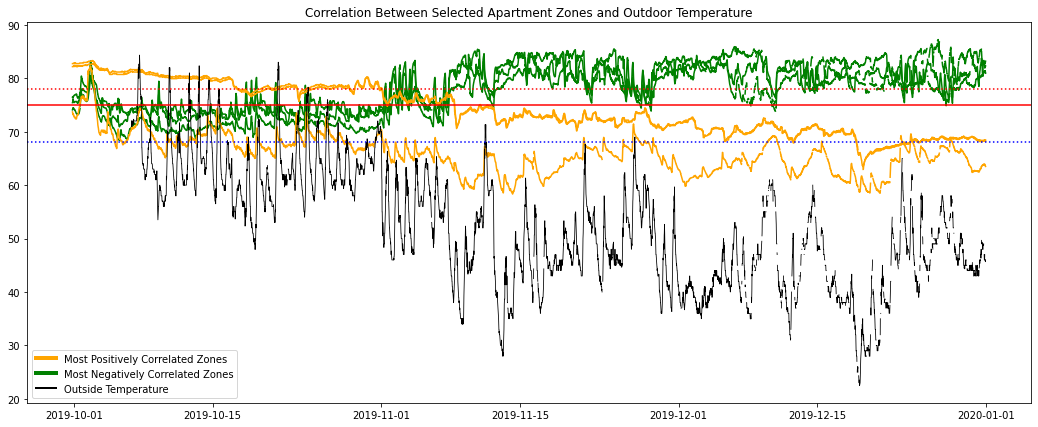

In [288]:
plt.figure(figsize=[18,7])
plt.plot(sensor_data.index,sensor_data[df.sort_values(by='Corr')[0:3]['Name']], color='green')
plt.plot(sensor_data.index,sensor_data[df.sort_values(by='Corr')[-5:-2]['Name']], color='orange')
# plt.legend(['Negatively Correlated to Outdoor Temp','Positively Correlated to Outdoor Temp'])
plt.plot(sensor_data.index,sensor_data['245 E 149th St. Controller [Tekmar 284] Outdoor Air Temperature'], 'k', linewidth=.8)
plt.axhline(y=78, color='r', linestyle=':')
plt.axhline(y=75, color='r', linestyle='-')
plt.axhline(y=68, color='b', linestyle=':')

legend_elements = [Line2D([0], [0], color='orange', lw=4, label='Most Positively Correlated Zones'),
                   Line2D([0], [0], color='green', lw=4,label='Most Negatively Correlated Zones'),
                  Line2D([0], [0], color='black', lw=2,label='Outside Temperature'),]
plt.legend(handles=legend_elements)
plt.title('Correlation Between Selected Apartment Zones and Outdoor Temperature')
# plt.xlim([sensor_data.index[1000],sensor_data.index[7000]])
plt.show()

Assuming that the Cozy would push down the heat from all the overheated buildings to 75f, and that this energy goes to the underheated apartments

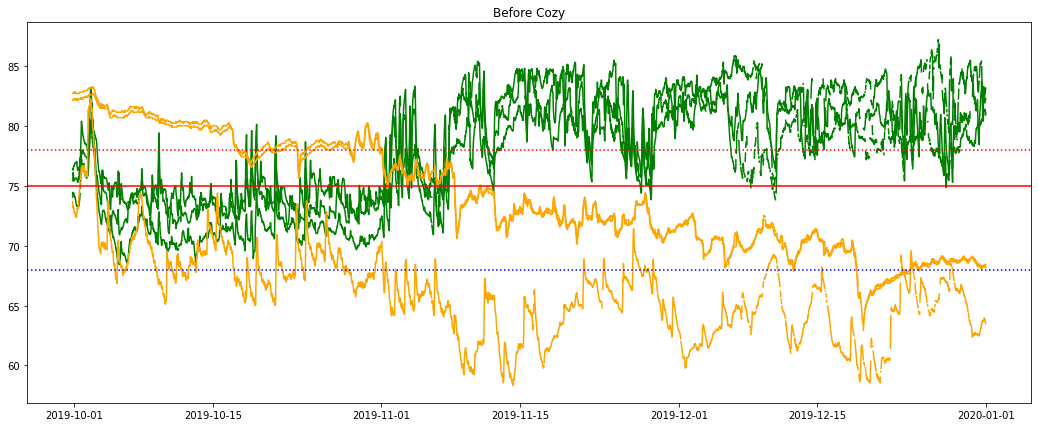

In [156]:
plt.figure(figsize=[18,7])
plt.plot(sensor_data.index,sensor_data[df.sort_values(by='Corr')[0:3]['Name']], color='green')
plt.plot(sensor_data.index,sensor_data[df.sort_values(by='Corr')[-5:-2]['Name']], color='orange')
plt.axhline(y=78, color='r', linestyle=':')
plt.axhline(y=75, color='r', linestyle='-')
plt.axhline(y=68, color='b', linestyle=':')
plt.title('Before Cozy')
# plt.xlim([sensor_data.index[1000],sensor_data.index[7000]])
plt.show()

In [ ]:
245 E 149th St. Controller [Tekmar 284] BAS Outdoor Air Temperature
245 E 149th St. Controller [Tekmar 284] Outdoor Air Temperature

In [203]:
sensor_apt_data = []

In [204]:
sensor_apt_data = sensor_data.drop(axis=1, columns=['245 E 149th St. Controller [Tekmar 284] BAS Outdoor Air Temperature','245 E 149th St. Controller [Tekmar 284] Outdoor Air Temperature'])

In [224]:
(sensor_apt_data-75).mean().sum()

998.1311158215332

Because of overheating there are many extra 'degrees F' available to play with

Assuming each overheated unit cools down by it's mean overheat, and each underheated unit heats up by it's mean underheat...

In [244]:
(sensor_apt_data-75).mean()

255 E 149th St. Floor-11 Apt-11E Zone Zone Temperature    2.045135
225 E 149th St. Floor-03 Apt-03A Zone Zone Temperature    2.477102
225 E 149th St. Floor-03 Apt-03B Zone Zone Temperature   -2.213455
225 E 149th St. Floor-03 Apt-03C Zone Zone Temperature    3.570166
225 E 149th St. Floor-03 Apt-03D Zone Zone Temperature    1.992254
                                                            ...   
255 E 149th St. Floor-10 Apt-10E Zone Zone Temperature    0.795590
255 E 149th St. Floor-11 Apt-11A Zone Zone Temperature    3.267855
255 E 149th St. Floor-11 Apt-11B Zone Zone Temperature   -1.767740
255 E 149th St. Floor-11 Apt-11C Zone Zone Temperature    0.521894
255 E 149th St. Floor-11 Apt-11D Zone Zone Temperature    4.767809
Length: 467, dtype: float64

In [260]:
sensor_apt_balanced = sensor_apt_data - (sensor_apt_data-75).median()

In [261]:
sensor_apt_balanced = sensor_apt_data.copy()

In [262]:
sensor_apt_balanced[sensor_apt_balanced > 78] = 78

In [263]:
sensor_apt_balanced[sensor_apt_balanced < 68] = 68

(55.0, 95.0)

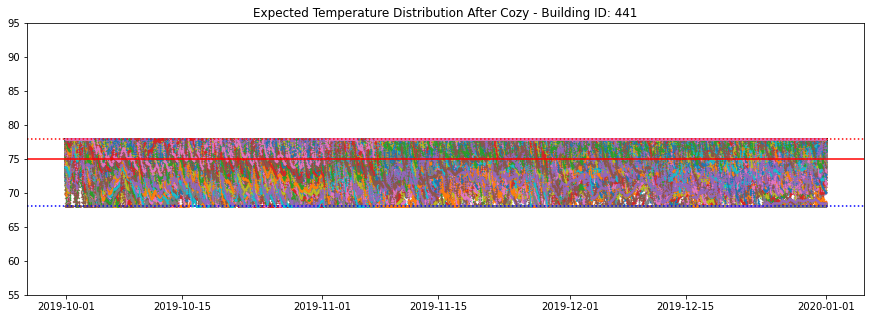

In [266]:
plt.figure(figsize=[15,5])
for col in sensor_apt_balanced.columns:
    plt.scatter(sensor_apt_balanced[col].index,sensor_apt_balanced[col], s=.2)

plt.axhline(y=78, color='r', linestyle=':')
plt.axhline(y=75, color='r', linestyle='-')
plt.axhline(y=68, color='b', linestyle=':')
plt.title('Expected Temperature Distribution After Cozy - Building ID: 441')
plt.ylim([55,95])


(55.0, 95.0)

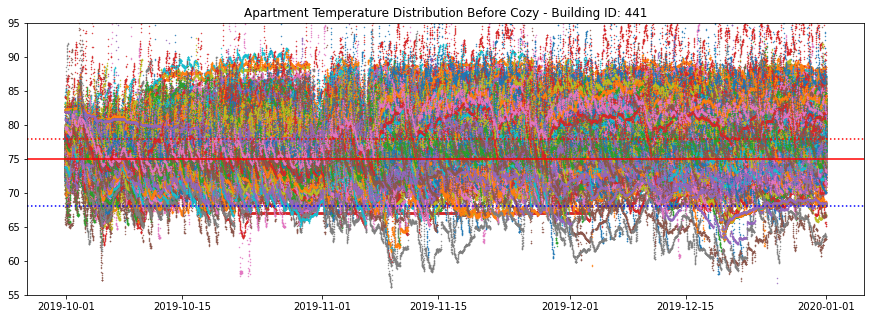

In [265]:
plt.figure(figsize=[15,5])
for col in sensor_apt_data.columns:
    plt.scatter(sensor_apt_data[col].index,sensor_apt_data[col], s=.2)

plt.axhline(y=78, color='r', linestyle=':')
plt.axhline(y=75, color='r', linestyle='-')
plt.axhline(y=68, color='b', linestyle=':')
plt.title('Apartment Temperature Distribution Before Cozy - Building ID: 441')
plt.ylim([55,95])

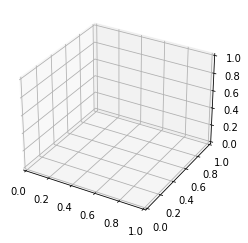

In [267]:
fig = plt.figure()
ax = plt.axes(projection='3d')

In [268]:
sensor_apt_data

255 E 149th St. Floor-11 Apt-11E Zone Zone Temperature  \
timestamp                                                                           
2019-09-30 20:15:00-04:00                                          80.674998        
2019-09-30 20:30:00-04:00                                          81.050001        
2019-09-30 20:45:00-04:00                                          81.237495        
2019-09-30 21:00:00-04:00                                          81.387497        
2019-09-30 21:15:00-04:00                                          81.387497        
...                                                                      ...        
2019-12-31 22:45:00-05:00                                          77.974996        
2019-12-31 23:00:00-05:00                                          77.899994        
2019-12-31 23:15:00-05:00                                          77.750000        
2019-12-31 23:30:00-05:00                                          77.618752        
2019-12-31 23:45:00-05:00                                          77.449997        

                           225 E 149th St. Floor-03 Apt-03A Zone Zone Temperature  \
timestamp                                                                           
2019-09-30 20:15:00-04:00                                          74.262502        
2019-09-30 20:30:00-04:00                                          74.374997        
2019-09-30 20:45:00-04:00                                          74.487495        
2019-09-30 21:00:00-04:00                                          74.412498        
2019-09-30 21:15:00-04:00                                          74.337502        
...                                                                      ...        
2019-12-31 22:45:00-05:00                                          78.012497        
2019-12-31 23:00:00-05:00                                          78.162501        
2019-12-31 23:15:00-05:00                                          78.275002        
2019-12-31 23:30:00-05:00                                          78.387497        
2019-12-31 23:45:00-05:00                                          78.462494        

                           225 E 149th St. Floor-03 Apt-03B Zone Zone Temperature  \
timestamp                                                                           
2019-09-30 20:15:00-04:00                                          74.300003        
2019-09-30 20:30:00-04:00                                          74.225001        
2019-09-30 20:45:00-04:00                                          74.112498        
2019-09-30 21:00:00-04:00                                          73.962494        
2019-09-30 21:15:00-04:00                                          73.812500        
...                                                                      ...        
2019-12-31 22:45:00-05:00                                          74.562495        
2019-12-31 23:00:00-05:00                                          74.524994        
2019-12-31 23:15:00-05:00                                          74.524994        
2019-12-31 23:30:00-05:00                                          74.524994        
2019-12-31 23:45:00-05:00                                          74.487495        

                           225 E 149th St. Floor-03 Apt-03C Zone Zone Temperature  \
timestamp                                                                           
2019-09-30 20:15:00-04:00                                          74.787501        
2019-09-30 20:30:00-04:00                                          74.750000        
2019-09-30 20:45:00-04:00                                          74.637497        
2019-09-30 21:00:00-04:00                                          74.637497        
2019-09-30 21:15:00-04:00                                          74.637497        
...                                                                      ...        
2019-12-31 22:45:00-05:00    

In [237]:
sensor_apt_balanced.columns

Index(['255 E 149th St. Floor-11 Apt-11E Zone Zone Temperature',
       '225 E 149th St. Floor-03 Apt-03A Zone Zone Temperature',
       '225 E 149th St. Floor-03 Apt-03B Zone Zone Temperature',
       '225 E 149th St. Floor-03 Apt-03C Zone Zone Temperature',
       '225 E 149th St. Floor-03 Apt-03D Zone Zone Temperature',
       '225 E 149th St. Floor-03 Apt-03E Zone Zone Temperature',
       '225 E 149th St. Floor-03 Apt-03F Zone Zone Temperature',
       '225 E 149th St. Floor-03 Apt-03G Zone Zone Temperature',
       '225 E 149th St. Floor-03 Apt-03H Zone Zone Temperature',
       '225 E 149th St. Floor-03 Apt-03J Zone Zone Temperature',
       ...
       '255 E 149th St. Floor-09 Apt-09E Zone Zone Temperature',
       '255 E 149th St. Floor-10 Apt-10A Zone Zone Temperature',
       '255 E 149th St. Floor-10 Apt-10B Zone Zone Temperature',
       '255 E 149th St. Floor-10 Apt-10C Zone Zone Temperature',
       '255 E 149th St. Floor-10 Apt-10D Zone Zone Temperature',
       '255 E 

In [ ]:
sensor_data.iloc[:,0].dropna()

In [ ]:
list(peak_idx)

In [ ]:
signal = sensor_data.iloc[:,0].dropna()

In [ ]:
signal = sensor_data.iloc[:,1].dropna()

peak_idx = find_peaks(signal, prominence=1)[0]
trough_idx = find_peaks(-signal, prominence=1, distance = 50)[0]

plt.figure(figsize=[18,5])
plt.plot(signal.index, signal, color='black')
plt.scatter(signal.iloc[peak_idx].index,signal.iloc[peak_idx])
plt.scatter(signal.iloc[trough_idx].index,signal.iloc[trough_idx])
plt.xlim(signal.index[3500],signal.index[3800])

Taking a look at building 375 for first order decay...

In [ ]:
query = PointSelector()
query.point_types = ['Zone Temperature', 'Outside Air Temperature', 'Status']
query.buildings = [375]
selection = client.select_points(query)

In [ ]:
sensor_metadata = pd.DataFrame(client.get_points_by_ids(selection['points']))

In [ ]:
sensor_metadata['type'].unique()

In [ ]:
sensor_metadata[sensor_metadata['type']  == 'Status']['name']

In [ ]:
sensor_metadata[sensor_metadata['type'] == 'Outside Air Temperature']['name'][50]

In [ ]:
sensor_metadata[sensor_metadata['type'] == 'Outside Air Temperature']['name'][54]

In [ ]:
start = datetime(2019, 10, 1, 0, 0, 0, 0, pytz.UTC)
end   = datetime(2020, 4, 1, 0, 0, 0, 0, pytz.UTC)

timeseries_query = TimeseriesQuery(point_ids = selection['points'], start = start, end = end)
sensor_data = points_df_from_streaming_timeseries(client.stream_point_timeseries(timeseries_query))

In [ ]:
sensor_data['timestamp'] = pd.to_datetime(sensor_data['timestamp'])

In [ ]:
sensor_data['timestamp'] = sensor_data['timestamp'].dt.tz_convert('US/Eastern')

In [ ]:
sensor_data = sensor_data.set_index('timestamp')

In [ ]:
sensor_metadata[['id','name']]

In [ ]:
name_for_col = []
for id in sensor_data.columns:
    name_for_col.append(sensor_metadata[sensor_metadata['id'] == id]['name'].values[0])

In [ ]:
len(name_for_col)

In [ ]:
len(sensor_data.columns)

In [ ]:
sensor_data.columns = name_for_col

In [ ]:
plt.plot(sensor_data['3400 Fort Independence Boiler 1 Boiler Status'])

In [ ]:
plt.plot(sensor_data['3400 Fort Independence Boiler 2 Boiler Status'])

In [ ]:
plt.figure(figsize=[18,5])
plt.plot(sensor_data.index, sensor_data)
plt.plot(sensor_data.index, sensor_data['3400 Fort Independence Boiler 1 Outside Air Temperature'], color='black')
plt.plot(sensor_data.index, sensor_data['3400 Fort Independence Street Boiler 1 Outside Air Temperature'], color='black')
# The latter outside air temp is trashhhh
plt.show()

In [ ]:
sensor_data['Boiler Status'] = sensor_data['3400 Fort Independence Boiler 1 Boiler Status'] + sensor_data['3400 Fort Independence Boiler 2 Boiler Status']

In [ ]:
sensor_data['3400 Fort Independence Boiler 2 Boiler Status'][11000:11050].dropna()

In [ ]:
plt.figure(figsize=[18,5])
plt.plot(sensor_data.index, sensor_data['3400 Fort Independence Apartment Sensors Apt 12C'])
plt.show()

In [ ]:
df = pd.DataFrame(list_of_stds)

In [ ]:
sum(df[0]>1.8)

In [ ]:
len(df)

In [ ]:
zone_temps_day = zone_temps.reset_index()
zone_temps_day['timestamp'] = zone_temps_day['timestamp'].dt.tz_convert('US/Eastern')
zone_temps_day = zone_temps_day.loc[(zone_temps_day['timestamp'].dt.hour > 9) & (zone_temps_day['timestamp'].dt.hour < 17)]
zone_temp_day = zone_temps_day.set_index('timestamp')

In [ ]:
stds_df = pd.DataFrame(list_of_stds)
stds_df.index = sensor_metadata.building_id.unique()
stds_df[stds_df[0] > 3]

In [ ]:
metadata_subset['id']

In [ ]:
metadata_subset['id']

In [ ]:
b_id = 441
std_val = 8.33
metadata_subset = sensor_metadata.loc[sensor_metadata['building_id'] == b_id]
zone_temps_subset = zone_temps[metadata_subset['id_str']]
zone_temps_subset = zone_temps_subset.reset_index()

subset_resampled = zone_temps_subset.resample('120min', on="timestamp").mean()

In [ ]:
len(amplitude_envelope)

In [ ]:
peaks = find_peaks(signal)[0]
peaks

In [ ]:
signal[peaks]

In [ ]:
signal[peaks].mean()

In [ ]:
plt.figure(figsize=[15,5])
plt.title('Building ID: ' + str(b_id) + ' Standard Deviation between Apartments: ' + str(std_val))
plt.plot(subset_resampled.index, subset_resampled)
    
mean_temp_ids = subset_resampled.mean().sort_values().index
mean_temp_values = subset_resampled.mean().sort_values().values
    
plt.figure(figsize=[15,5])
plt.title('Building ID: ' + str(b_id) + ' Standard Deviation between Apartments: ' + str(std_val))
plt.plot(subset_resampled[mean_temp_ids[0]].index, subset_resampled[mean_temp_ids[0]], color='blue')

plt.plot(subset_resampled[mean_temp_ids[-1]].index, subset_resampled[mean_temp_ids[-1]], color='red')
plt.plot(signal[peaks].index,signal[peaks], color='black')

plt.legend(['Coolest Apartment', 'Hottest Apartment'])
plt.show()

In [ ]:
mean_temp_ids

In [ ]:
sensor_metadata[sensor_metadata['building_id'] == 441]

In [ ]:
query = PointSelector()
query.point_types = ['Zone Temperature']
query.buildings = [441]
selection = client.select_points(query)

In [ ]:
selection['point_types']

In [ ]:
all_point_types = pd.DataFrame(client.get_all_point_types())

In [ ]:
all_point_types[all_point_types['id'].isin(selection['point_types'])]

In [ ]:
# query = PointSelector()
# # query.point_types = ['Outside Air Temperature']
# query.buildings = [441]
# selection = client.select_points(query)

In [ ]:
selection['points']

In [ ]:
sensor_metadata = pd.DataFrame(client.get_points_by_ids(selection['points']))

In [ ]:
start = datetime(2019, 10, 1, 0, 0, 0, 0, pytz.UTC)
end   = datetime(2020, 4, 1, 0, 0, 0, 0, pytz.UTC)

timeseries_query = TimeseriesQuery(point_ids = selection['points'], start = start, end = end)
sensor_data = points_df_from_streaming_timeseries(client.stream_point_timeseries(timeseries_query))

In [ ]:
sensor_data

In [ ]:
sensor_data['timestamp'] = pd.to_datetime(sensor_data['timestamp'])

In [ ]:
plt.figure(figsize=[15,5])
plt.title('Building ID: ' + str(b_id) + ' Standard Deviation between Apartments: ' + str(std_val))
plt.plot(subset_resampled.index, subset_resampled)
    
mean_temp_ids = subset_resampled.mean().sort_values().index
mean_temp_values = subset_resampled.mean().sort_values().values
    
plt.figure(figsize=[15,5])
plt.title('Building ID: ' + str(b_id) + ' Standard Deviation between Apartments: ' + str(std_val))
plt.plot(subset_resampled[mean_temp_ids[0]].index, subset_resampled[mean_temp_ids[0]])
plt.plot(subset_resampled[mean_temp_ids[-1]].index, subset_resampled[mean_temp_ids[-1]])
plt.legend(['Hottest Apartment', 'Coldest Apartment'])

# plt.plot(sensor_data['timestamp'], sensor_data[310903], color='black')

plt.show()

